In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Mon Sep 21 15:49:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   30C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def param_search(neural_network_class, product, 
                 Xtrain, Ttrain, Xtest, Ttest,
                 epochs, batch_size, method, lr, verbose=False, **kwargs):
    # https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715
    
    train_history = []
    val_history = []

    best = float('inf')
    best_nnet = None
    best_info = None
    
    f = FloatProgress(min=0, max=len(layers))
    display(f)
    for activation, layer in product:
        if 'Convolutional' in str(neural_network_class):
            nnet = neural_network_class(Xtrain.shape[1:], layer, kwargs['kernels_size_and_stride']*len(layer),
                                        Ttrain.shape[1], activation=activation)
        else:
            nnet = neural_network_class(Xtrain.shape[1], layer, Ttrain.shape[1],
                                        activation=activation)
        
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method,
                   learning_rate=lr, verbose=verbose, validation=[Xtest, Ttest])

        train_history.append(nnet.history['rmse'][-1])

        temp = nnet.history['val_rmse'][-1]
        val_history.append(temp)

        if temp < best:
            best = temp
            best_nnet = nnet
            best_info = {'epochs': epochs, 'batch_size': batch_size,
                         'method': method, 'lr': lr, 'activation': activation,
                         'layers': layer}
        f.value += 1
        
    print(best_info)
    return best_nnet, train_history, val_history


def plot_param_search(product, train_history, val_history, rotation=30):
    train_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.NWP_LINE_COLOUR_KEY]
    val_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_history, 'o-', color=train_color)
    plt.plot(val_history, 'o-', color=val_color)

    best_index = np.argmin(val_history)
    best = val_history[best_index]

    plt.hlines(best, 0, len(product) - 1, linestyle='dashed', color='black')
    plt.plot(best_index, best, 'k*', markersize=12)
    plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
               rotation=rotation, horizontalalignment='right')

    plt.legend(('Train', 'Validation', f'Best: {best:.3f}'))
    plt.grid(True); plt.title('Network Variance')
    plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE (C)');

# Data Loader

In [16]:
raob, rap, goes, rtma, sonde_files = dataloader.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 735 samples!


FloatProgress(value=0.0, max=735.0)

time: 18.633, avg: 0.025 seconds
(735, 256, 4) (735, 256, 4) (735, 3, 3, 8) (735, 3, 3, 3)


In [5]:
ml.rmse(rap[:,:,DEWPOINT], raob[:,:,DEWPOINT]), ml.rmse(rap[:,:,TEMPERATURE], raob[:,:,TEMPERATURE])

(4.810772620409847, 1.3815068064243756)

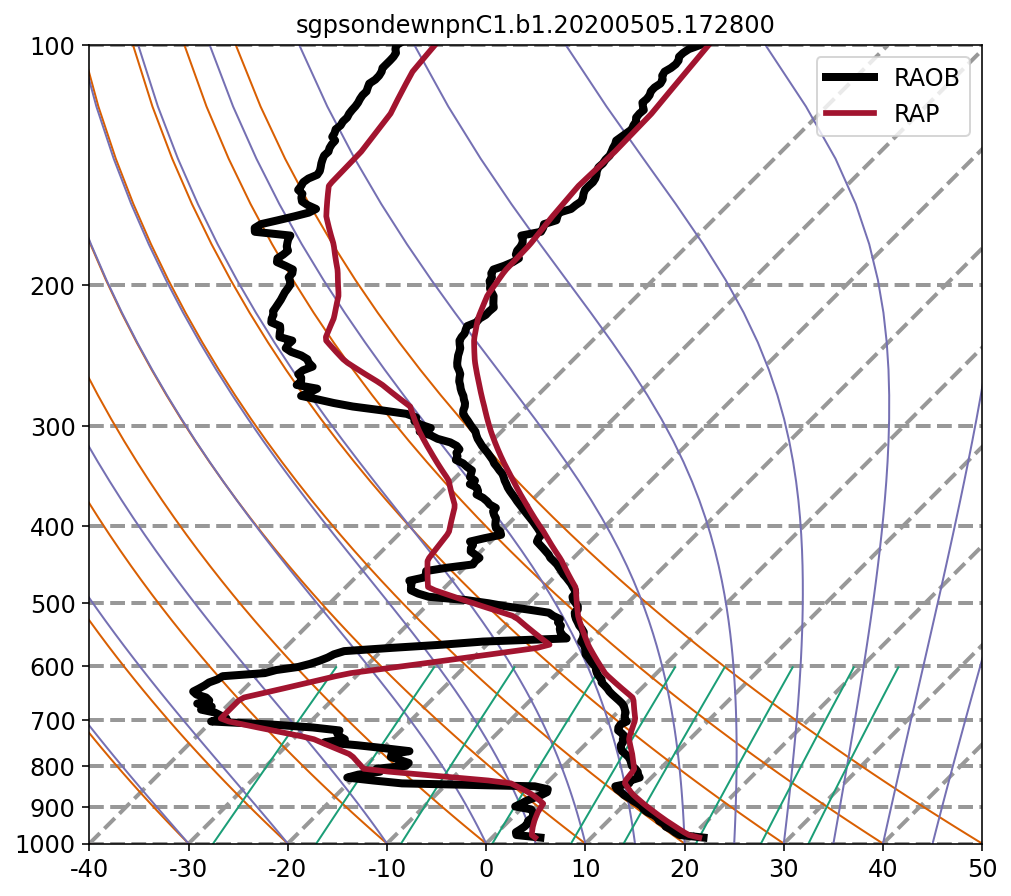

In [9]:
index = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

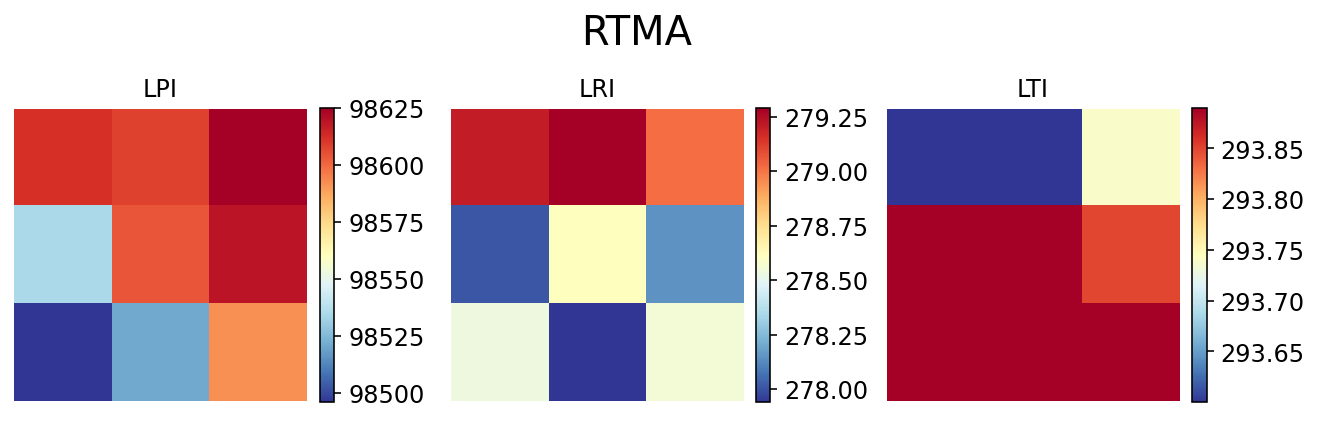

In [10]:
rtma_type = np.array(['LPI', 'LRI', 'LTI'])

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], cmap=PLOT_CMAP)
    fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f'{str(rtma_type[i])}')
fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()

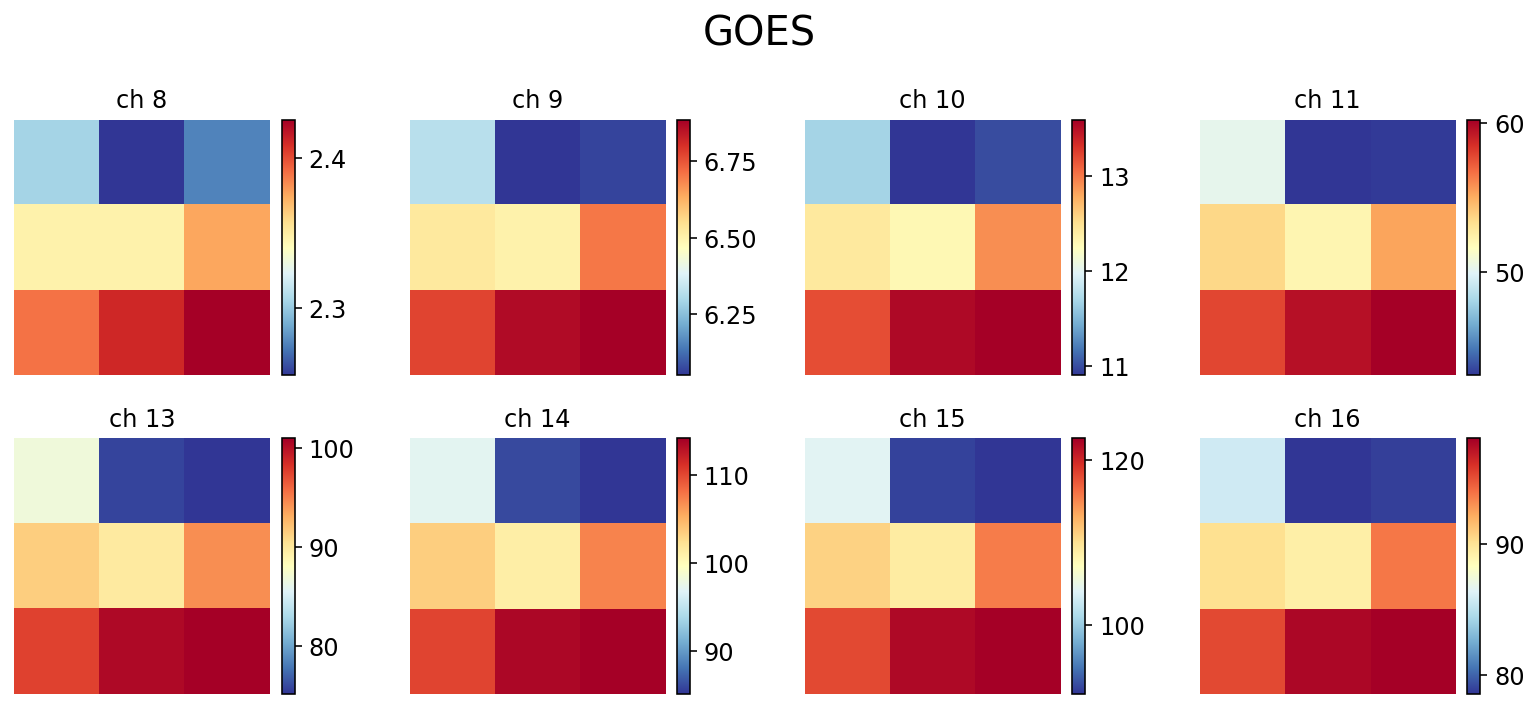

In [11]:
bands = np.array([8, 9, 10, 11, 13, 14, 15, 16])

# vmin = goes[index,:,:,:].min()
# vmax = goes[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(11,5))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    c = axs[r, i % 4].imshow(goes[index,:,:,i], cmap=PLOT_CMAP) # vmin=vmin, vmax=vmax,
    cbar = fig.colorbar(c, ax=axs[r, i % 4], fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=3)
    axs[r, i % 4].set_title(f'ch {str(bands[i])}')
plt.suptitle('GOES', fontsize=20)
fig.tight_layout()

# RAP

- [Linear](#Linear-NN)
- [Fully Connected](#Fully-Connected-NN)
- [Conv1D NN](#Conv1D-NN)
- [CAE NN](#CAE-NN)
- [Transfer Learning RAOB](#Transfer-Learning-RAOB)

## Linear NN

### Temperature

In [17]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8, 0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

# Flatten inputs to (n, 4) and (n, 1) vectors
# input_dims = [PRESSURE, TEMPERATURE, DEWPOINT, ALTITUDE]
# Xt = Xtrain[:,:,input_dims]
# Xt = Xt.reshape(-1, Xt.shape[-1])
# Tt = Ttrain[:,:,[TEMPERATURE]]
# Tt = Tt.reshape(-1, Tt.shape[-1])
# Xe = Xtest[:,:,input_dims]
# Xe = Xe.reshape(-1, Xe.shape[-1])
# Te = Ttest[:,:,[TEMPERATURE]]
# Te = Te.reshape(-1, Te.shape[-1])

Xt.shape, Tt.shape, Xe.shape, Te.shape

((588, 512), (588, 256), (147, 512), (147, 256))

In [18]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, rmse 3.91724, val_rmse 2.62568
epoch: 5, rmse 1.31226, val_rmse 1.34834
epoch: 10, rmse 1.15407, val_rmse 1.20836
epoch: 15, rmse 1.10503, val_rmse 1.18166
epoch: 20, rmse 1.08917, val_rmse 1.15183
epoch: 25, rmse 1.07723, val_rmse 1.15593
epoch: 30, rmse 1.06381, val_rmse 1.12624
epoch: 35, rmse 1.04793, val_rmse 1.13321
epoch: 40, rmse 1.04365, val_rmse 1.13465
epoch: 45, rmse 1.05310, val_rmse 1.13866
epoch: 49, rmse 1.03966, val_rmse 1.12194
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.05586 in 3.1643 seconds.

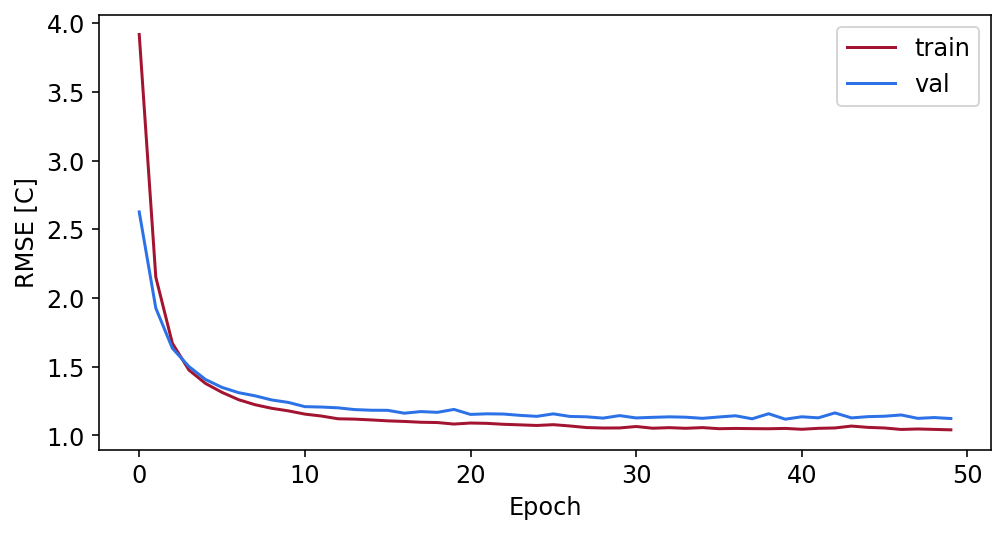

In [20]:
results.plot_loss(nnet)

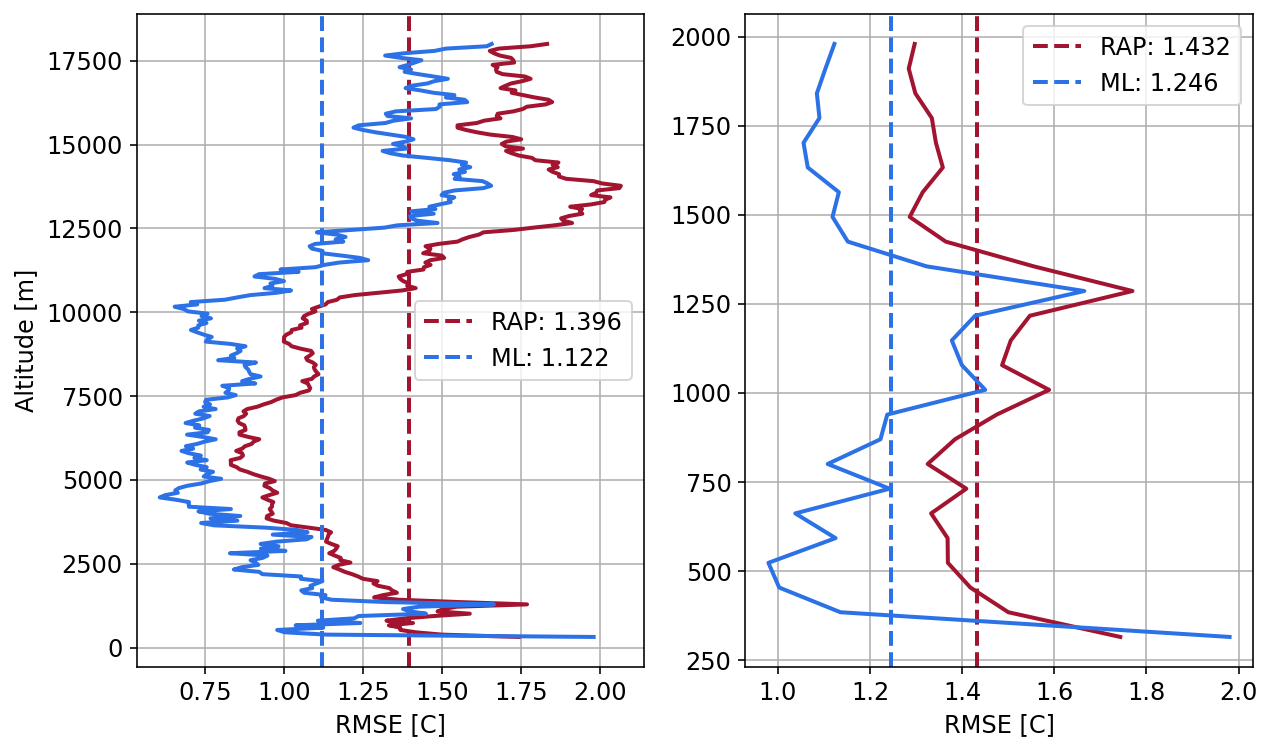

In [22]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,TEMPERATURE], alt=raob[0, :, -1])

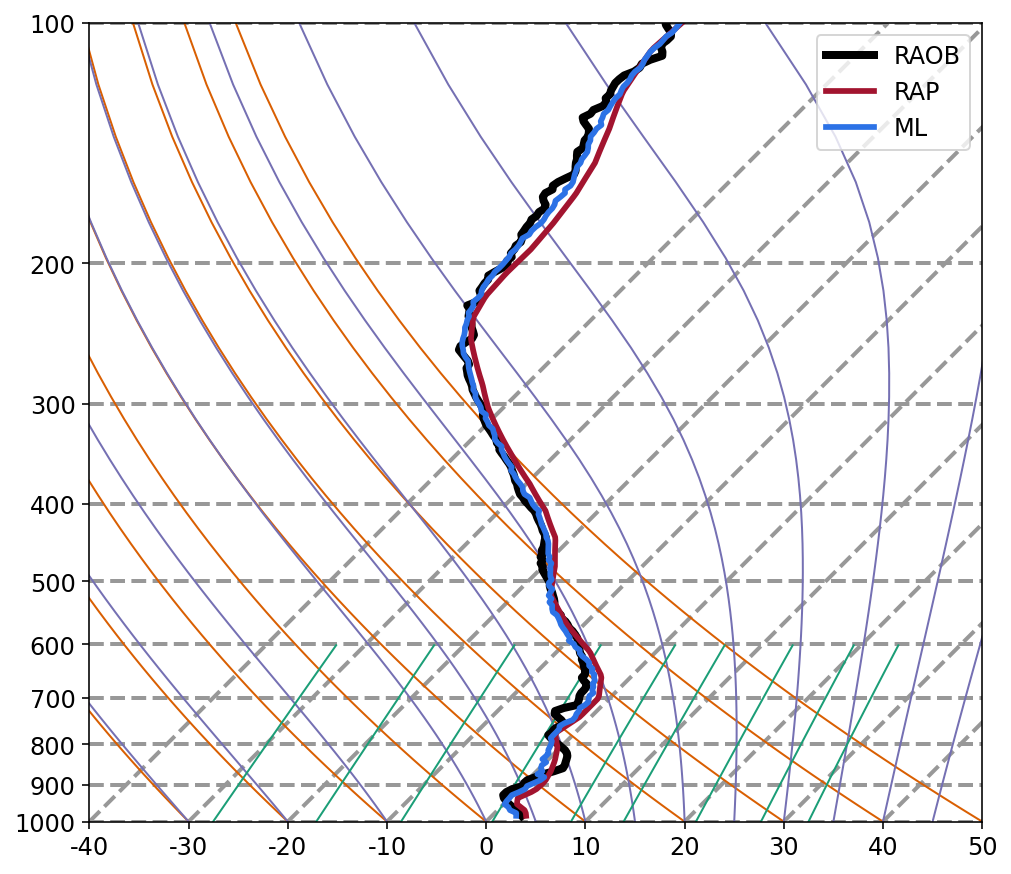

In [13]:
i = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [14]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((588, 512), (588, 256), (147, 512), (147, 256))

In [15]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

# nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

epoch: 0, rmse 8.21102, val_rmse 6.07617
epoch: 5, rmse 4.11981, val_rmse 4.19845
epoch: 10, rmse 3.89262, val_rmse 4.08227
epoch: 15, rmse 3.83724, val_rmse 4.05328
epoch: 20, rmse 3.84070, val_rmse 3.97682
epoch: 25, rmse 3.77786, val_rmse 4.01295
epoch: 30, rmse 3.79753, val_rmse 4.02918
epoch: 35, rmse 3.78605, val_rmse 4.03224
epoch: 40, rmse 3.75395, val_rmse 4.06295
epoch: 45, rmse 3.83435, val_rmse 3.99866
epoch: 49, rmse 3.75497, val_rmse 4.02991
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.32557 in 3.1879 seconds.

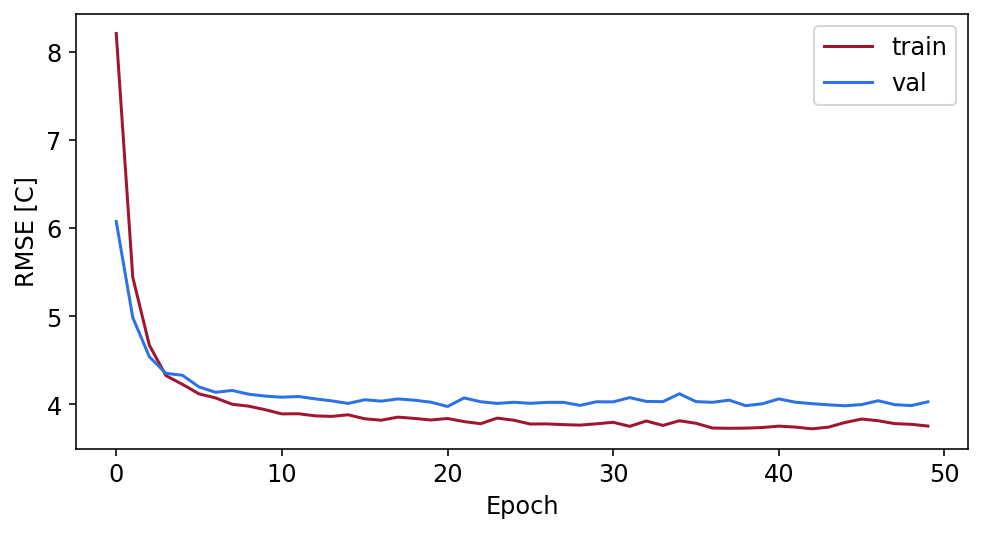

In [16]:
plot_loss(nnet)

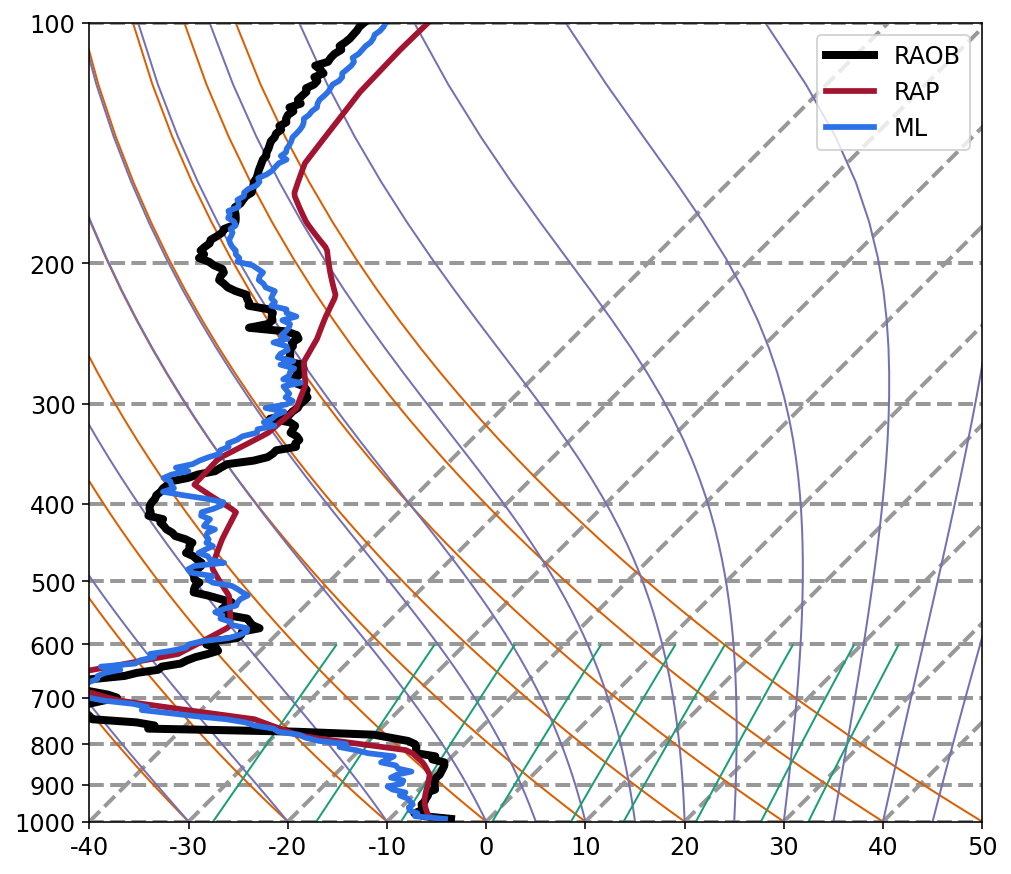

In [17]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

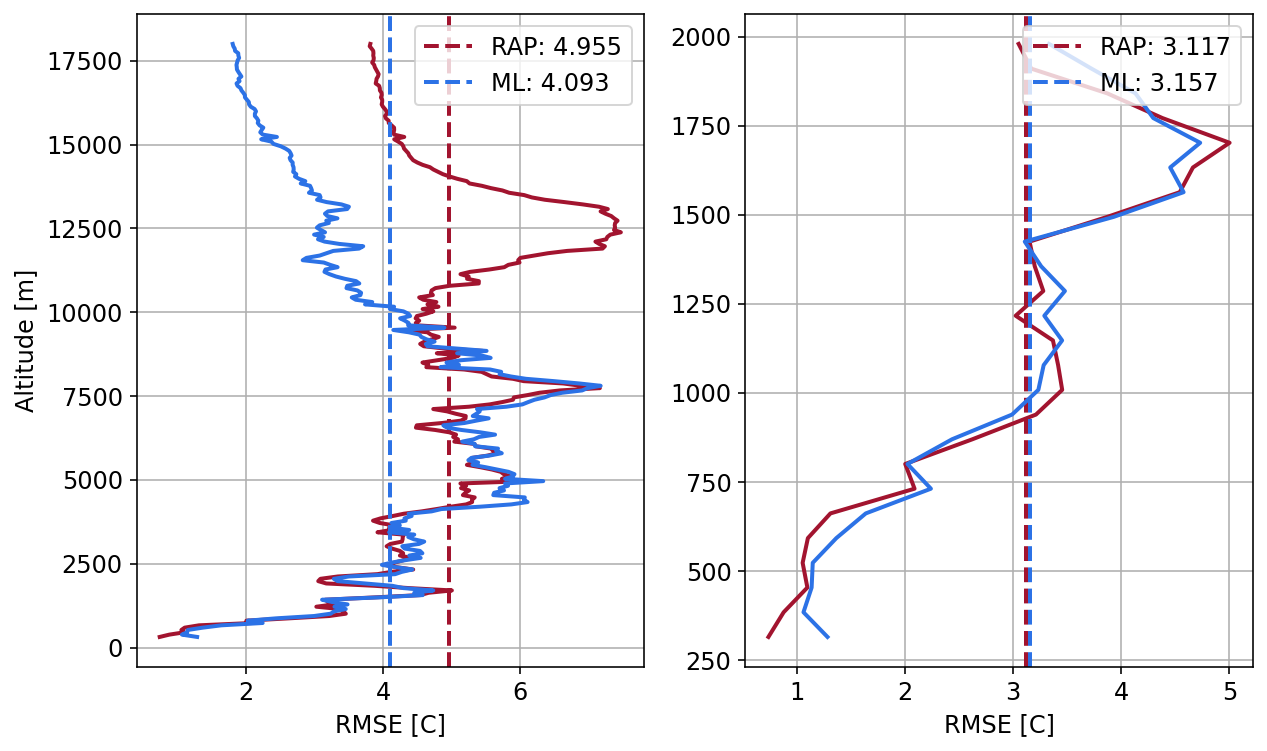

In [18]:
plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,DEWPOINT], alt=raob[0, :, -1])

## Fully Connected NN

In [62]:
A = np.array([[[1, 1, 1, 1],[0, 0, 0, 0]],
              [[2, 2, 2, 2],[5, 5, 5, 5]]])
A.shape, A.mean(axis=0)

((2, 2, 4),
 array([[1.5, 1.5, 1.5, 1.5],
        [2.5, 2.5, 2.5, 2.5]]))

### Temperature

In [70]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((588, 512), (588, 256), (147, 512), (147, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 50, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'relu', 'layers': [64]}


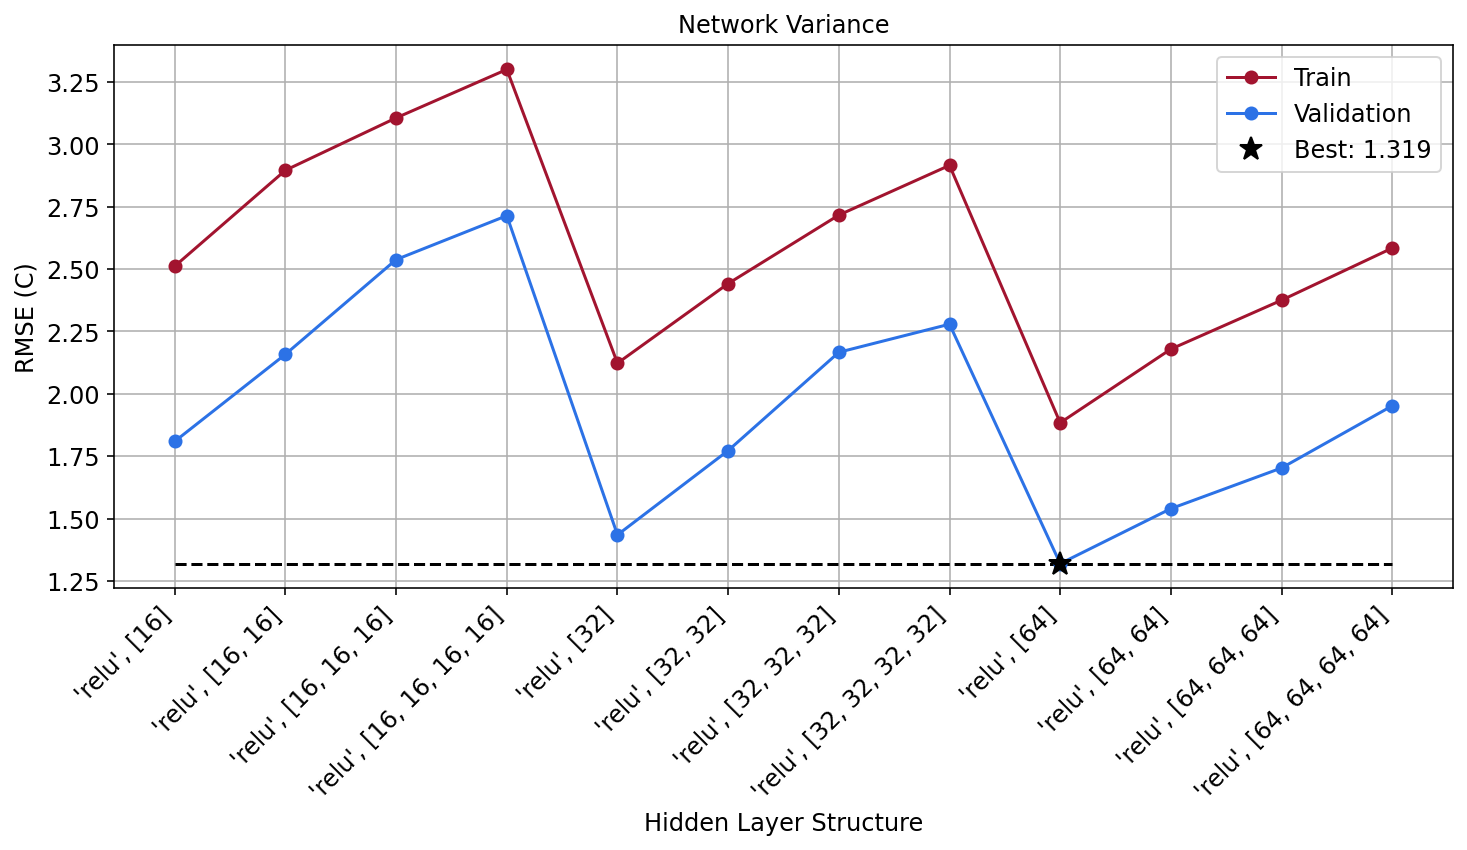

In [71]:
activations = ['relu']
layers = [[nu] * nl for nu in [16, 32, 64] for nl in range(1, 5)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=50, batch_size=32, method='adam', lr=0.001, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

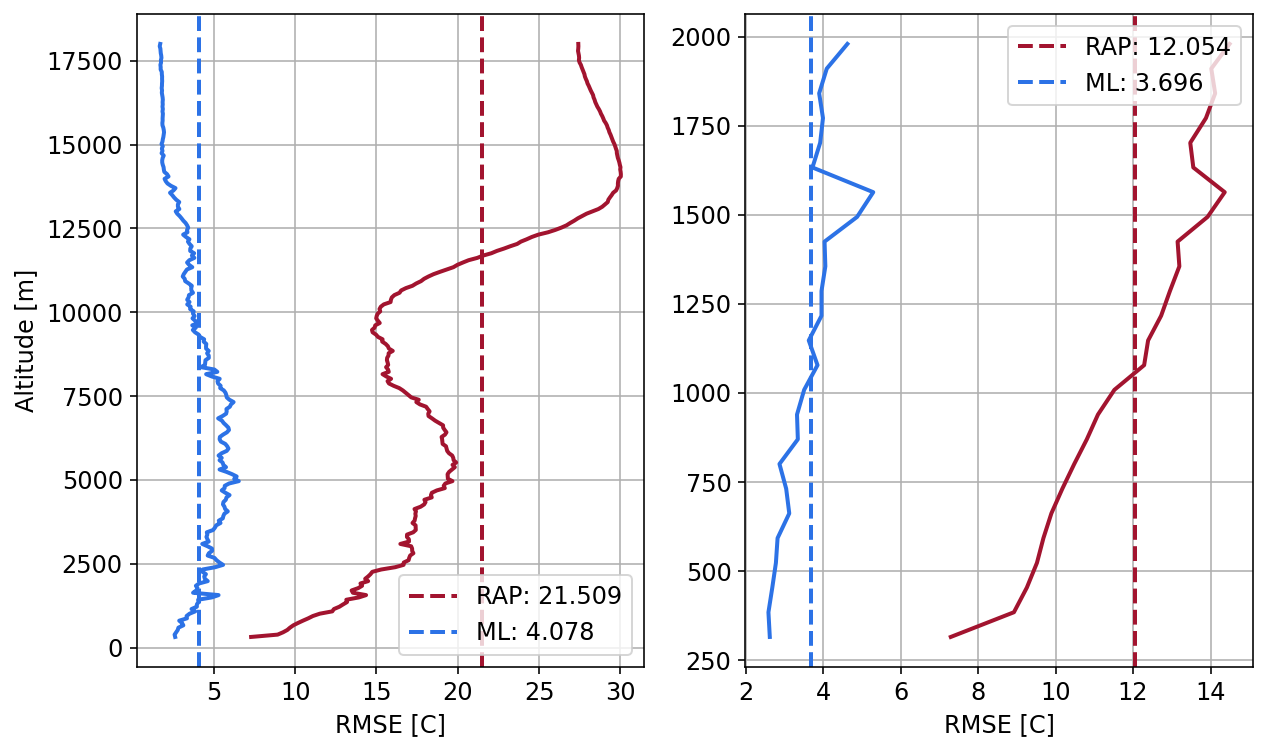

In [67]:
plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,TEMPERATURE], alt=raob[0, :, -1])

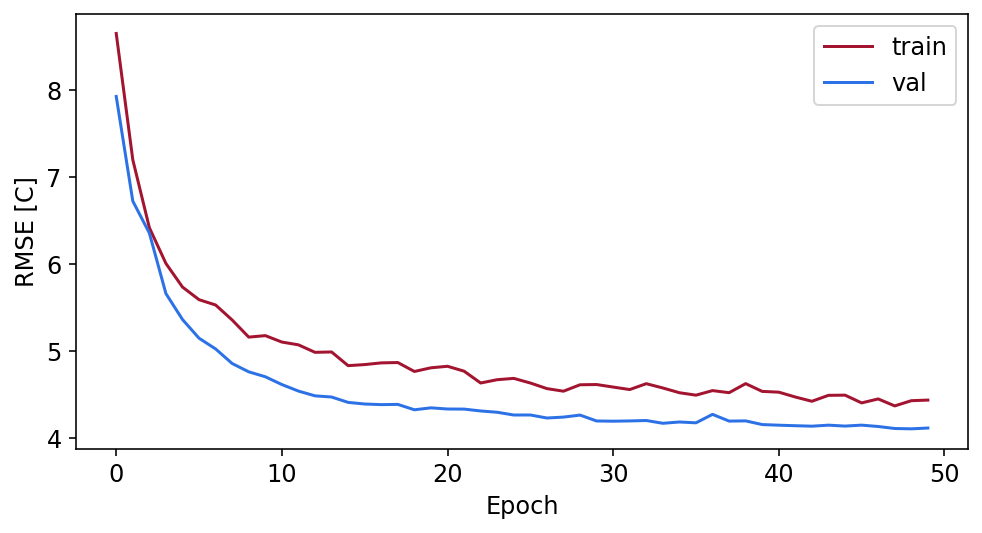

In [68]:
plot_loss(nnet)

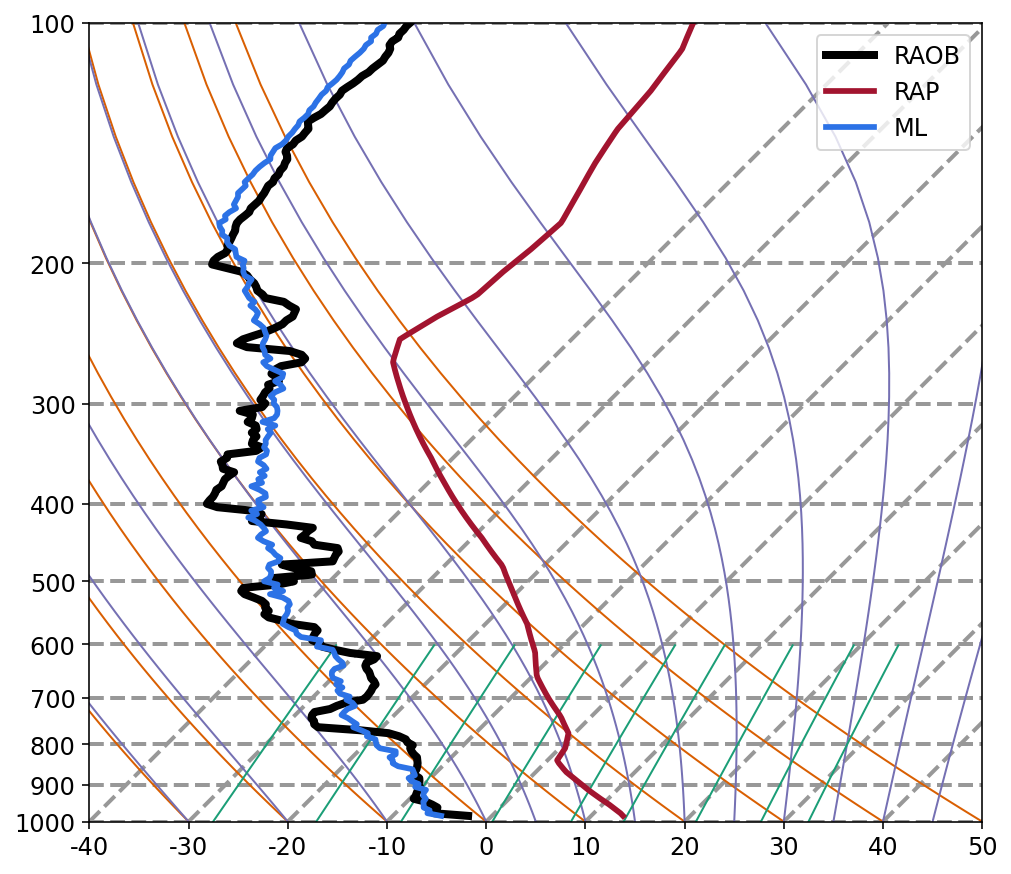

In [69]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [19]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((588, 512), (588, 256), (147, 512), (147, 256))

FloatProgress(value=0.0, max=18.0)

{'epochs': 50, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'relu', 'layers': [128]}


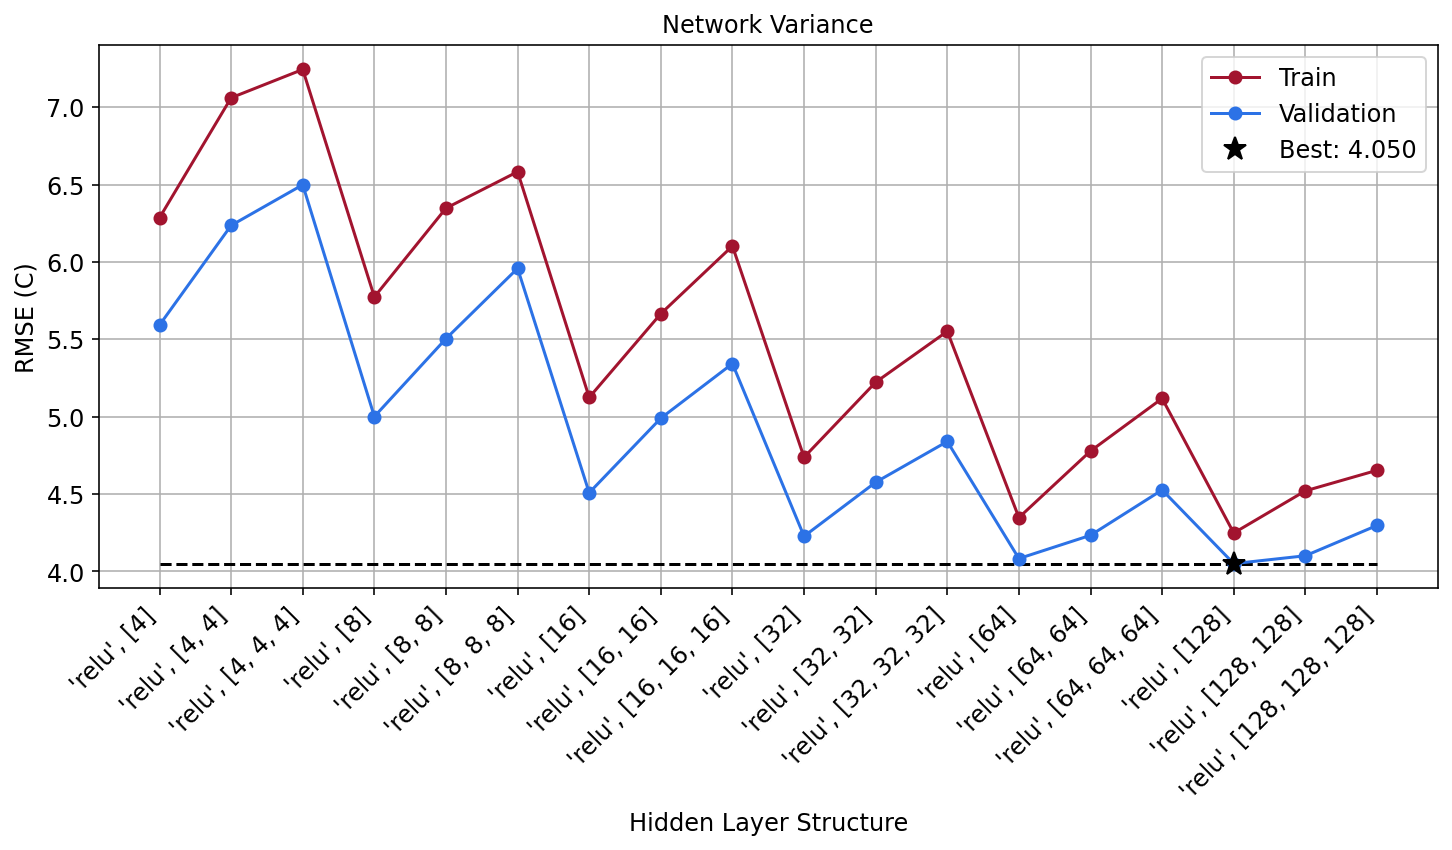

In [20]:
activations = ['relu']
layers = [[nu] * nl for nu in [4, 8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=50, batch_size=32, method='adam', lr=0.001, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

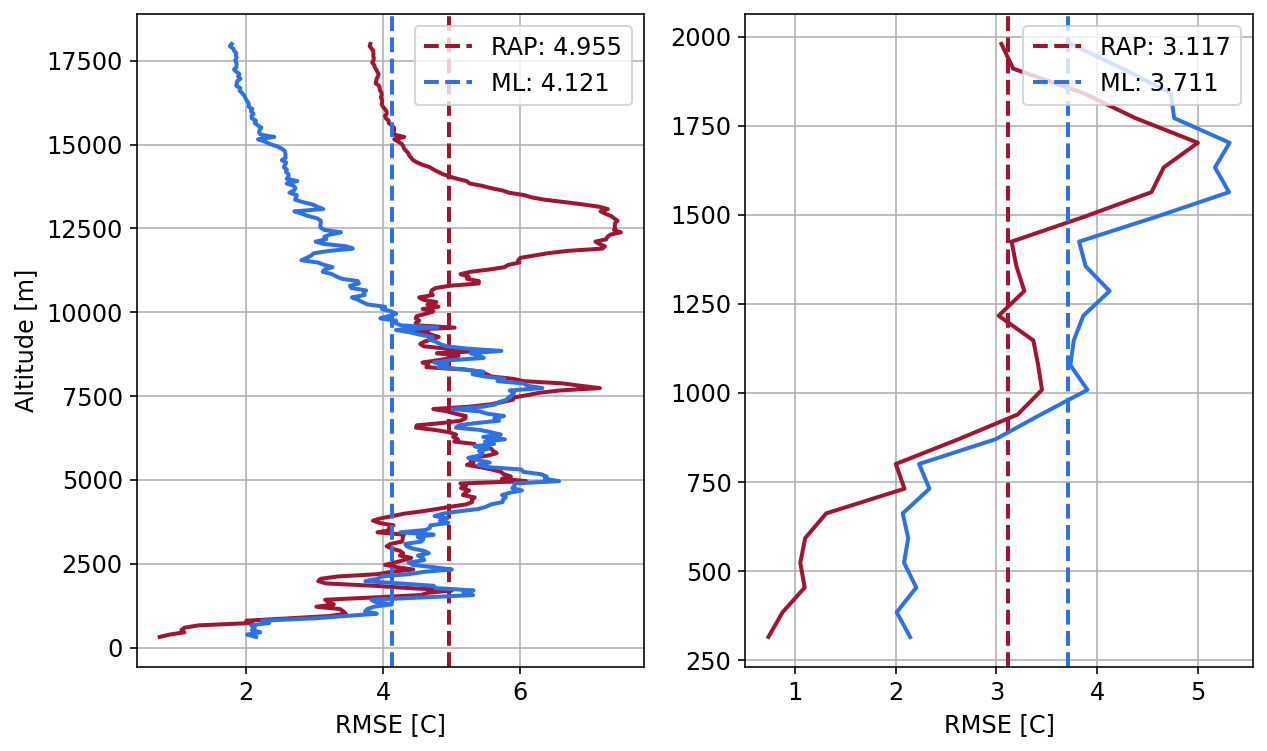

In [21]:
plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,DEWPOINT], alt=raob[0, :, -1])

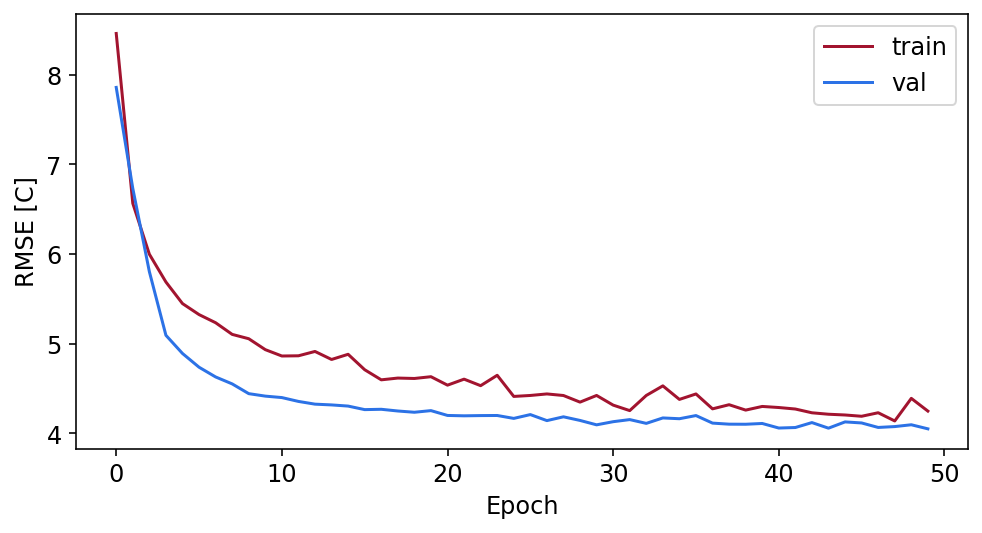

In [22]:
plot_loss(nnet)

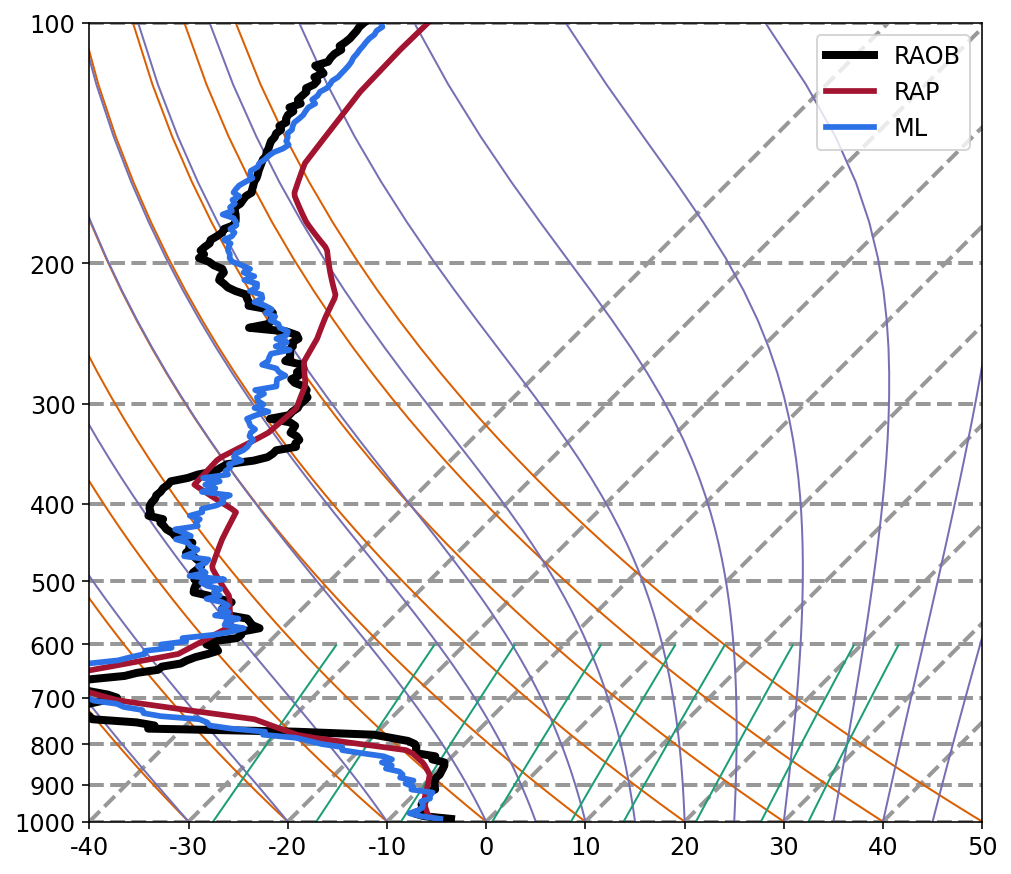

In [23]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

### Temperature

In [82]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

FloatProgress(value=0.0, max=17.0)

{'epochs': 25, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [64]}


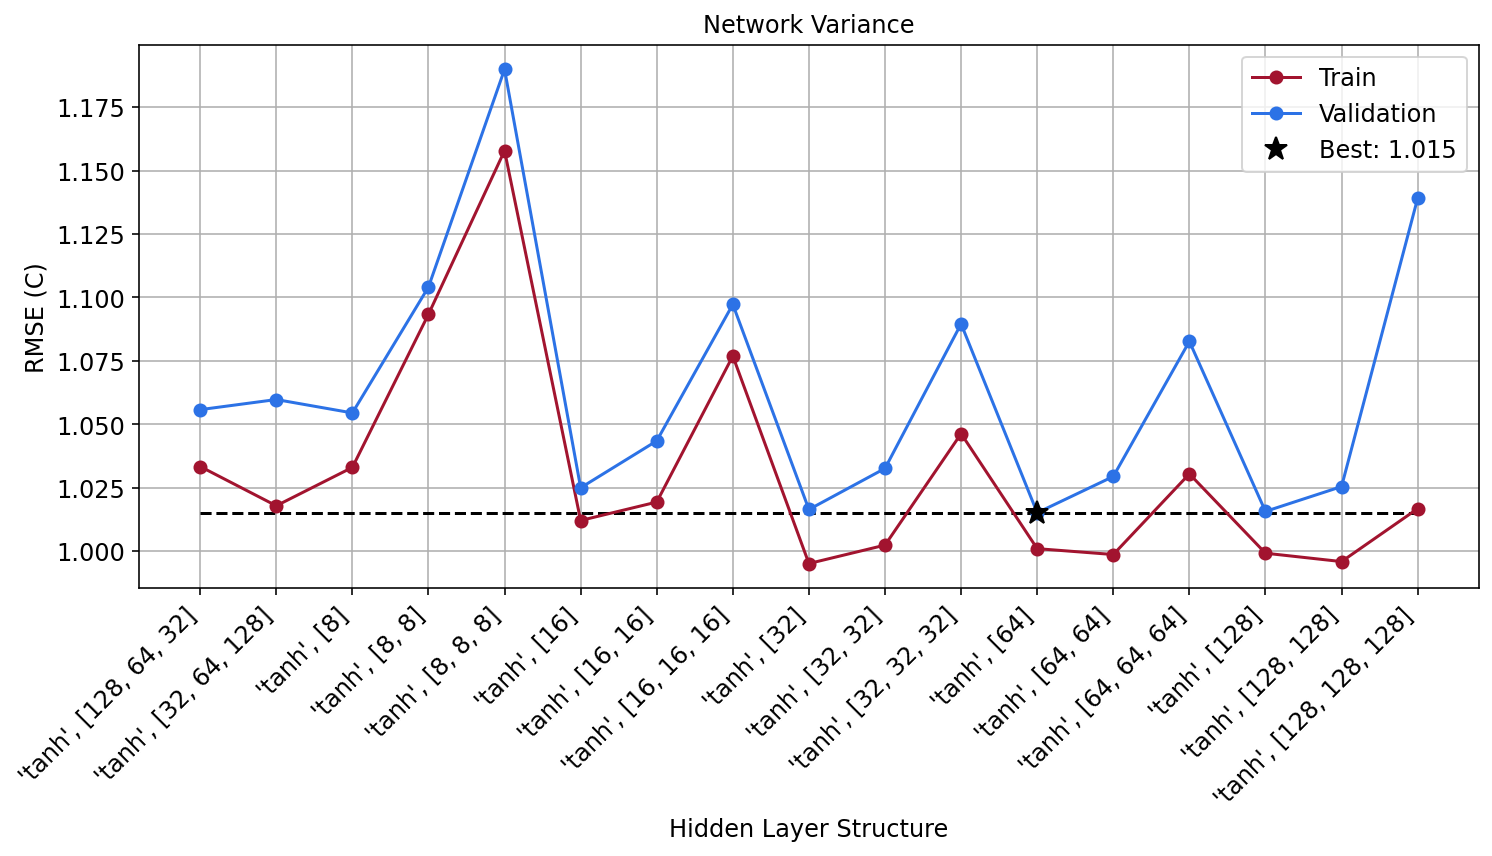

In [83]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=25, batch_size=32, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

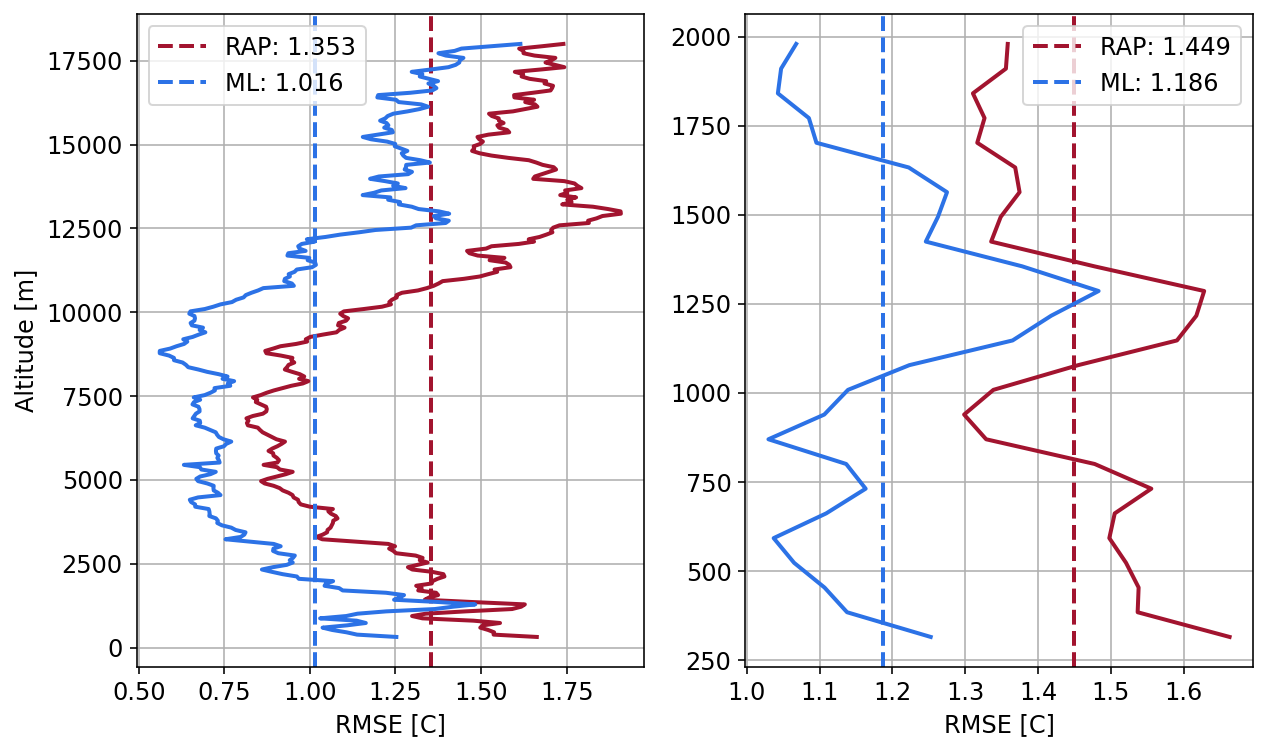

In [84]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE], alt=raob[0, :, -1])

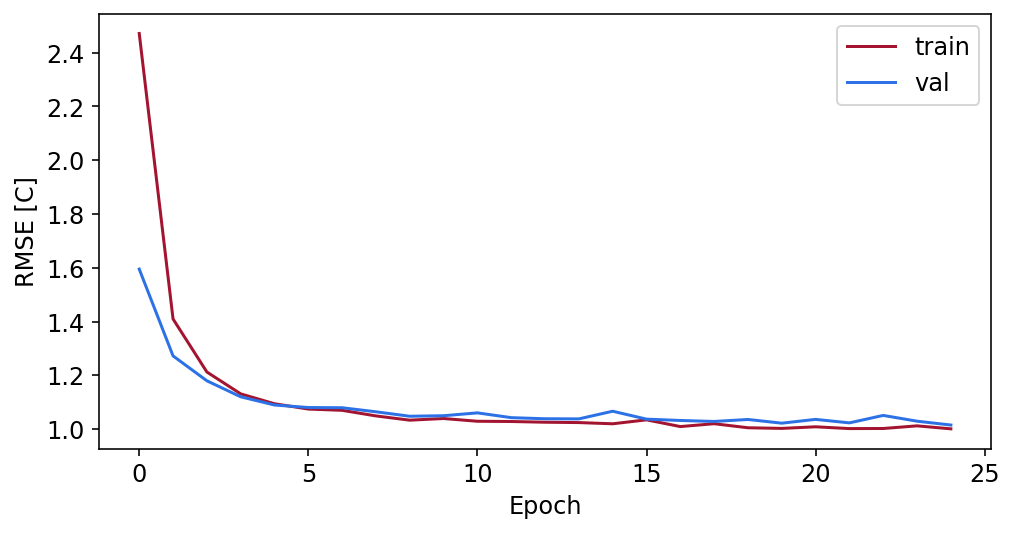

In [85]:
plot_loss(nnet)

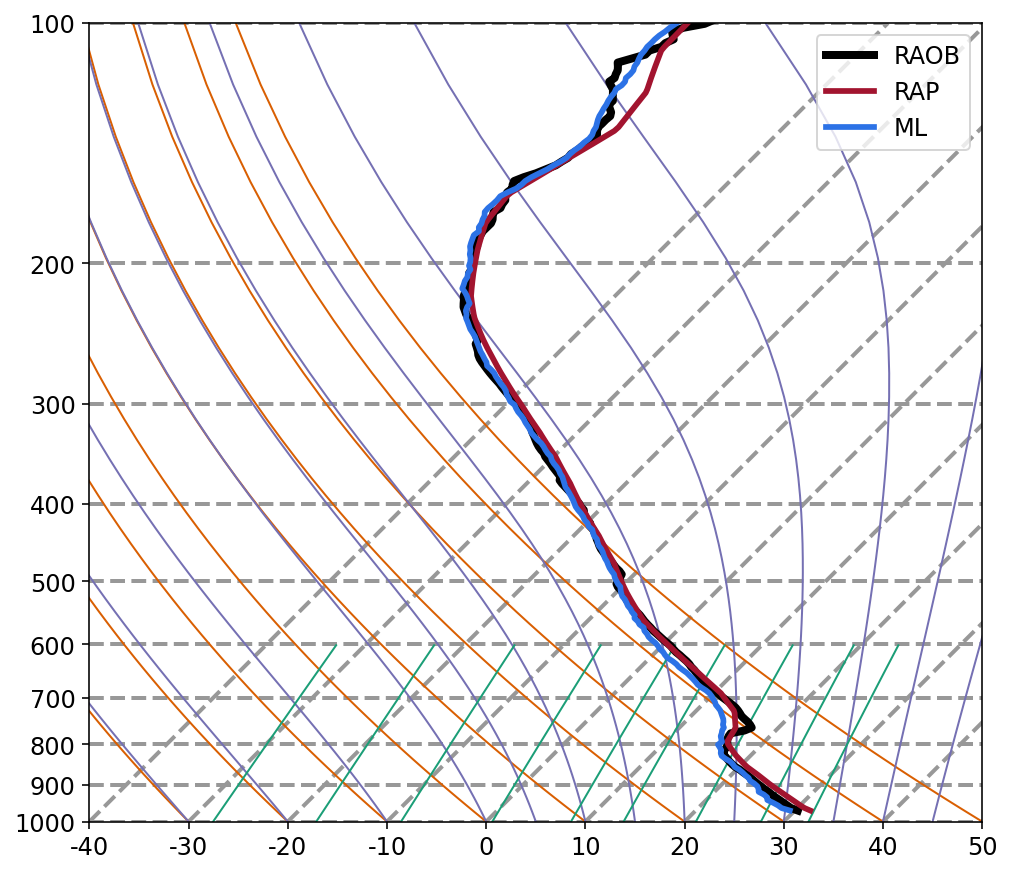

In [86]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

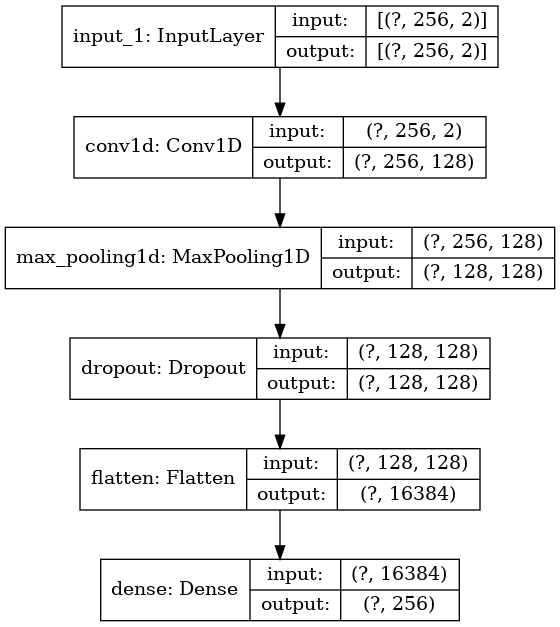

In [21]:
tf.keras.utils.plot_model(best_nnet.model, '/home/stock/research/media/rap_only_network.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [35]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

FloatProgress(value=0.0, max=17.0)

{'epochs': 25, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [16]}


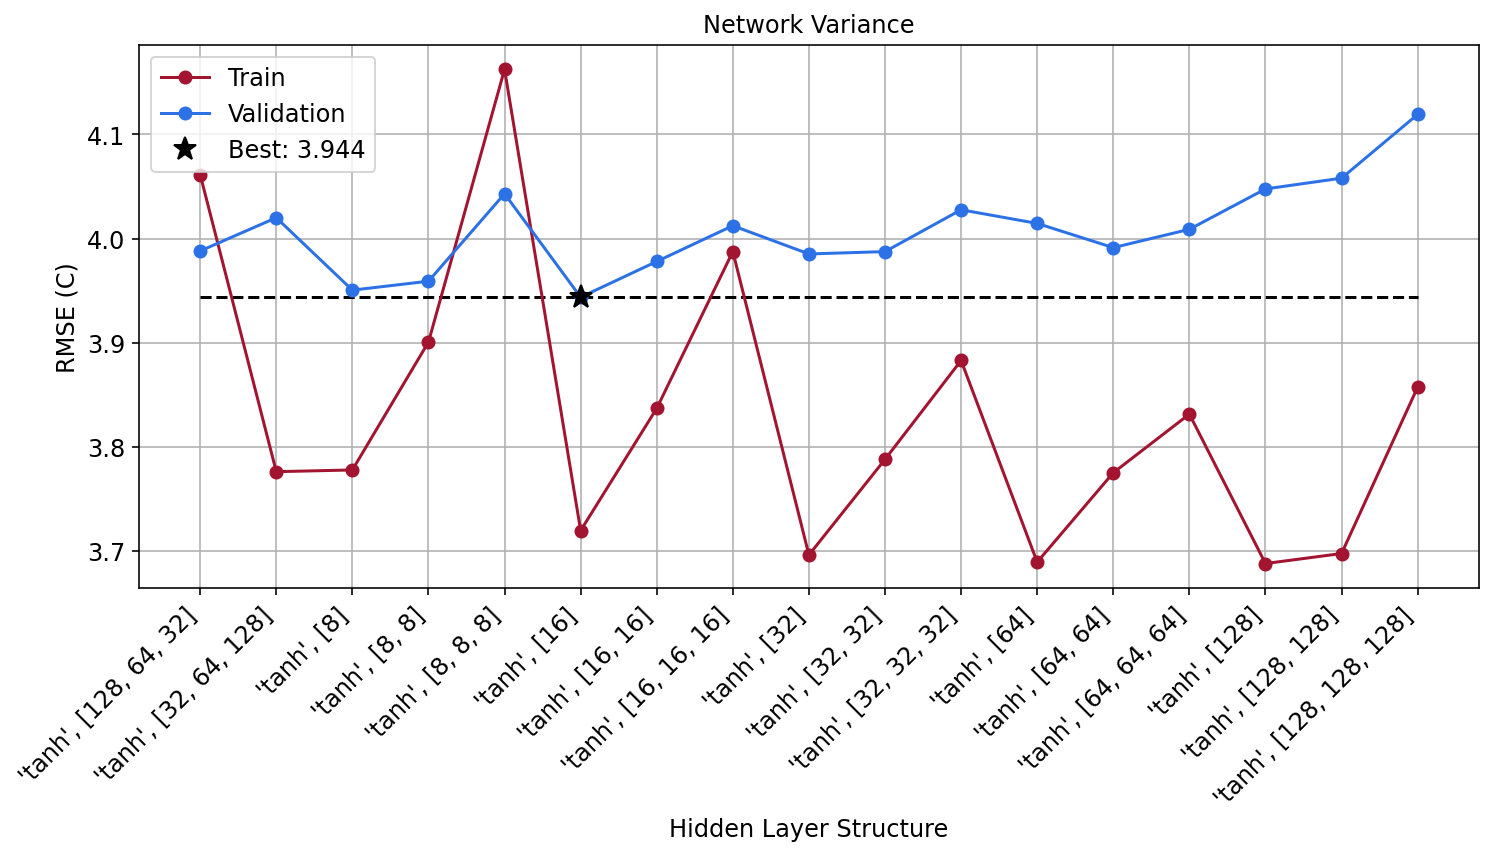

In [36]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=25, batch_size=32, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

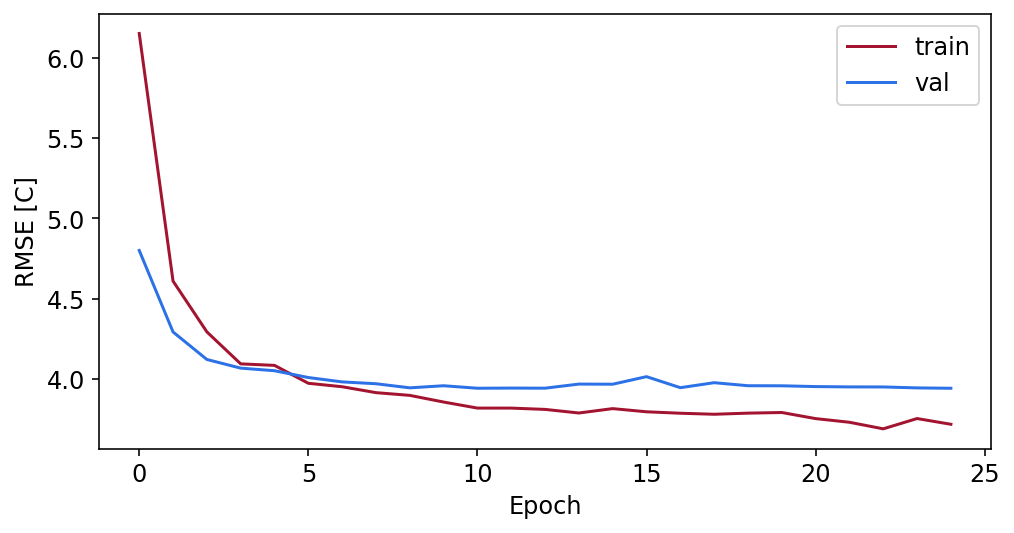

In [37]:
plot_loss(nnet)

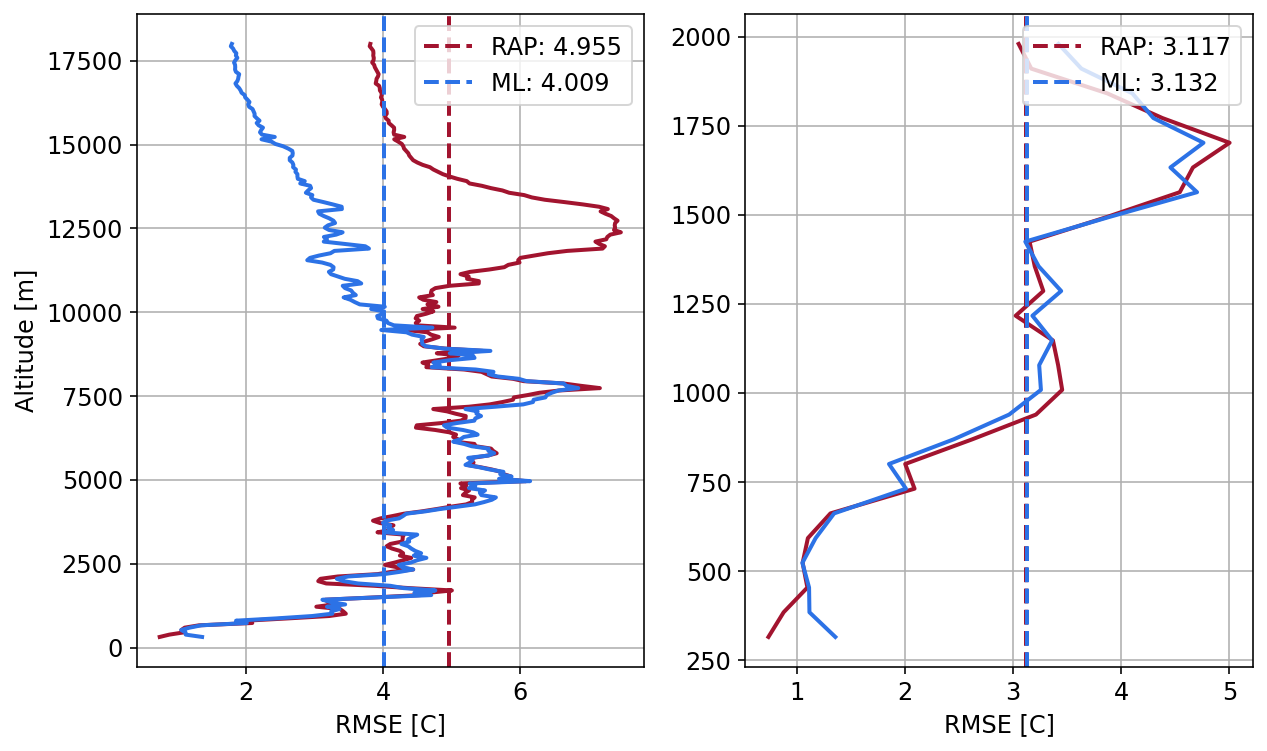

In [38]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])

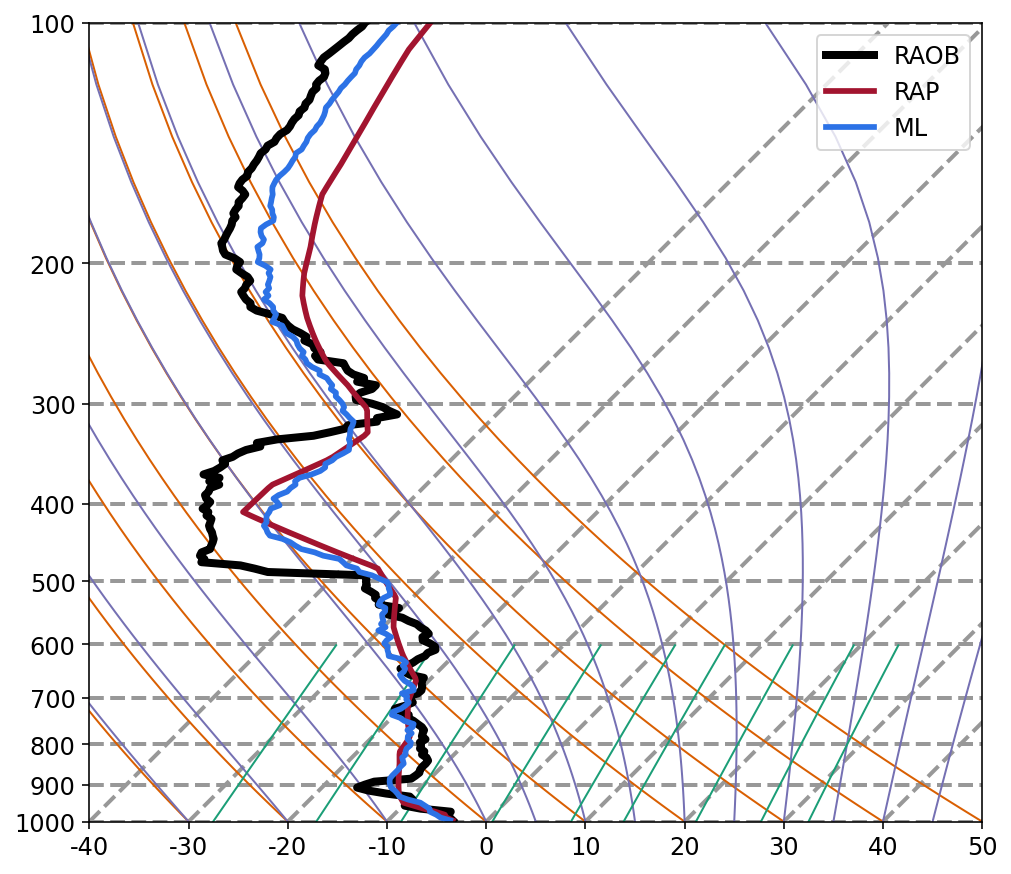

In [39]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtrain[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## CAE NN

### Temperature

In [87]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [8, 8]}


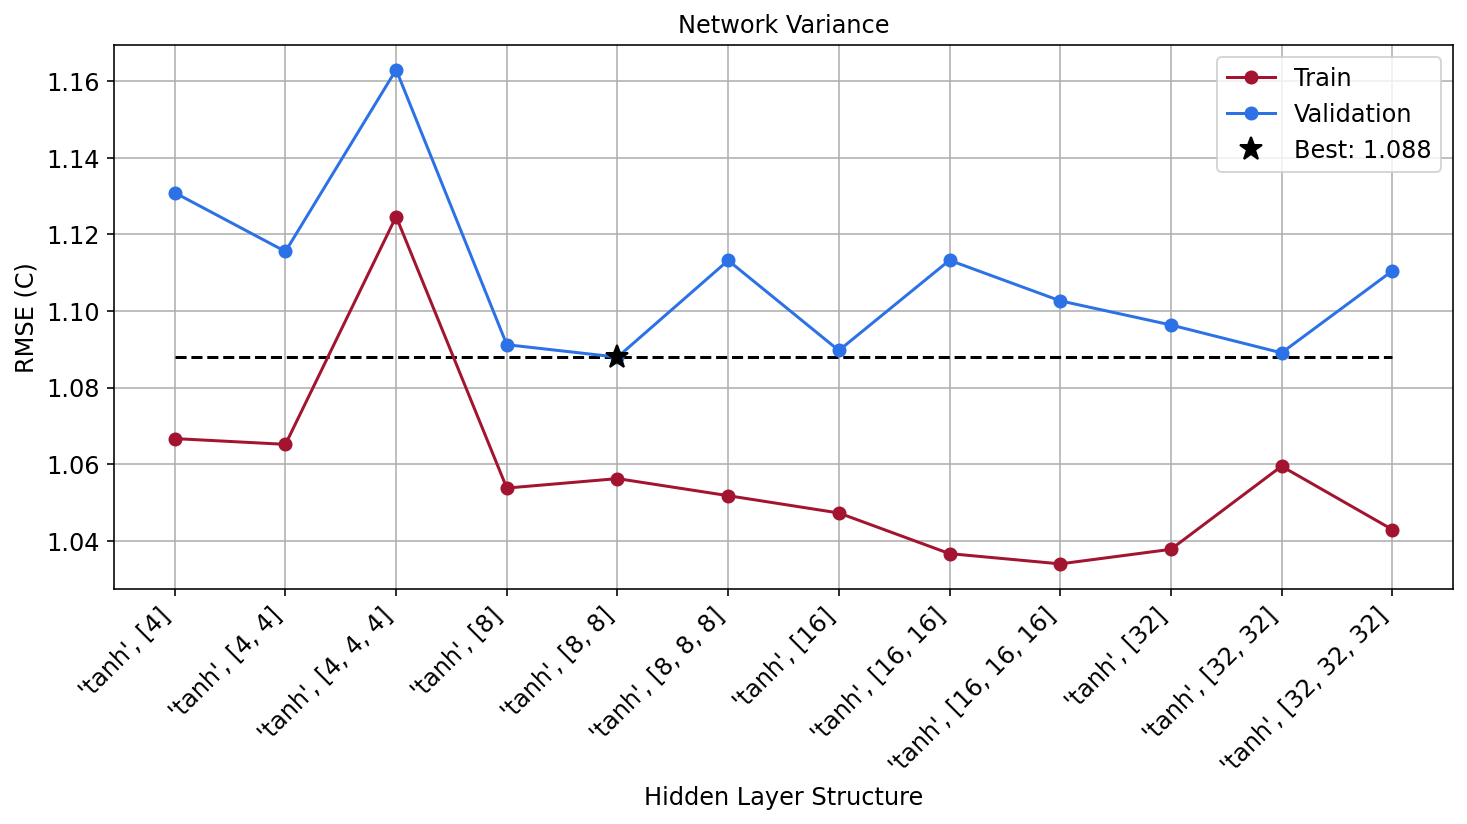

In [91]:
activations = ['tanh']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

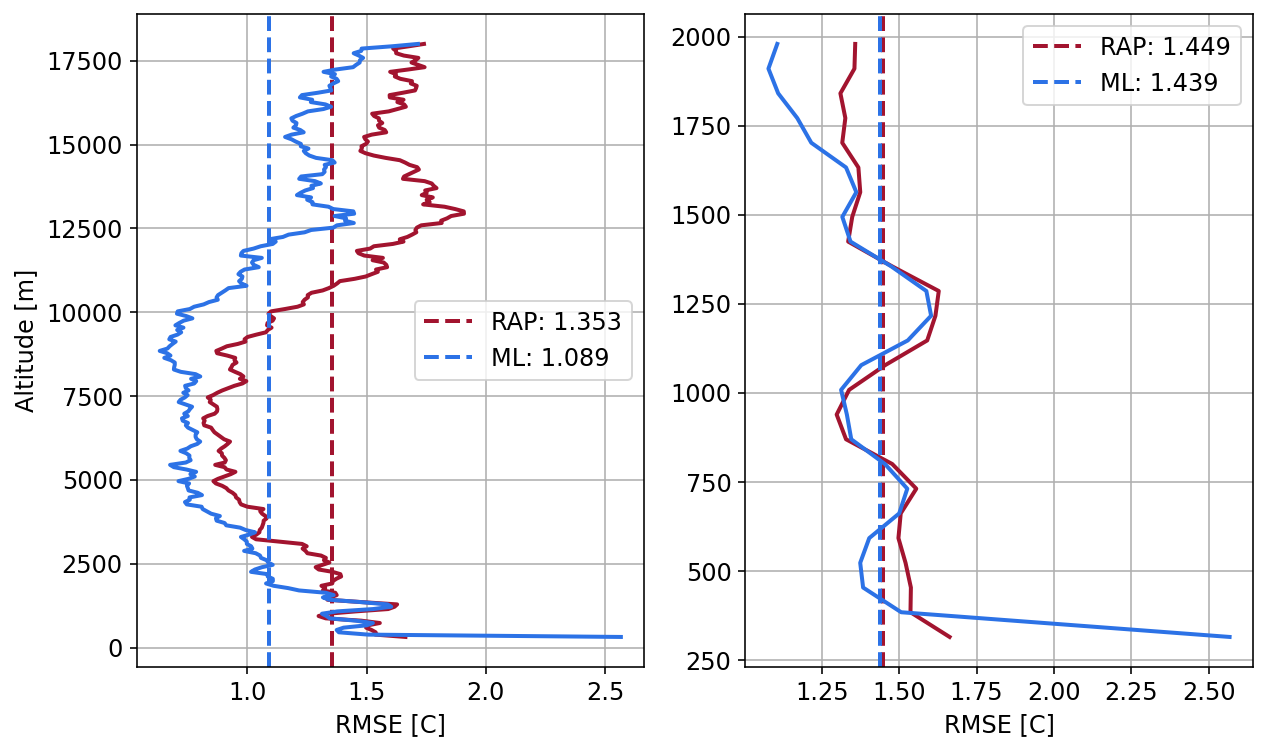

In [92]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

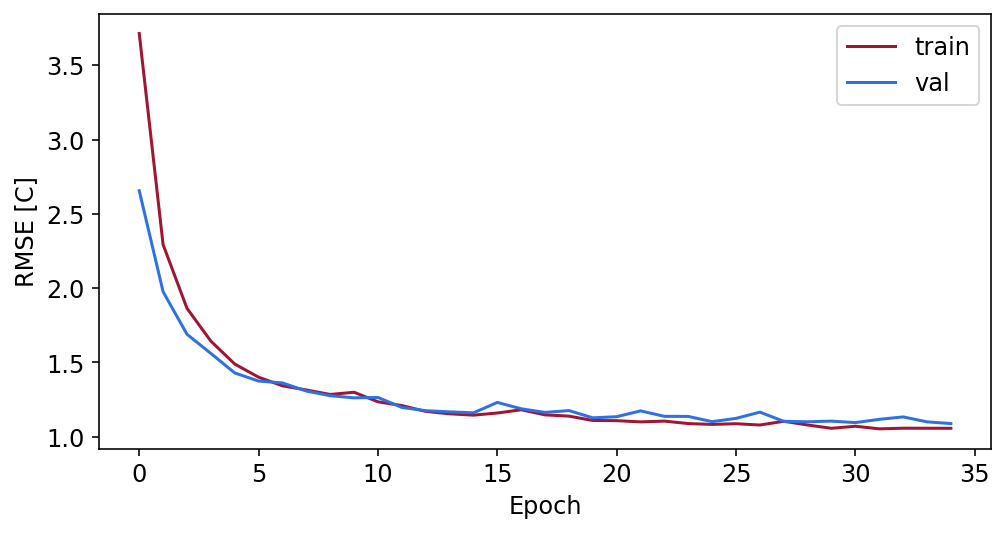

In [93]:
plot_loss(nnet)

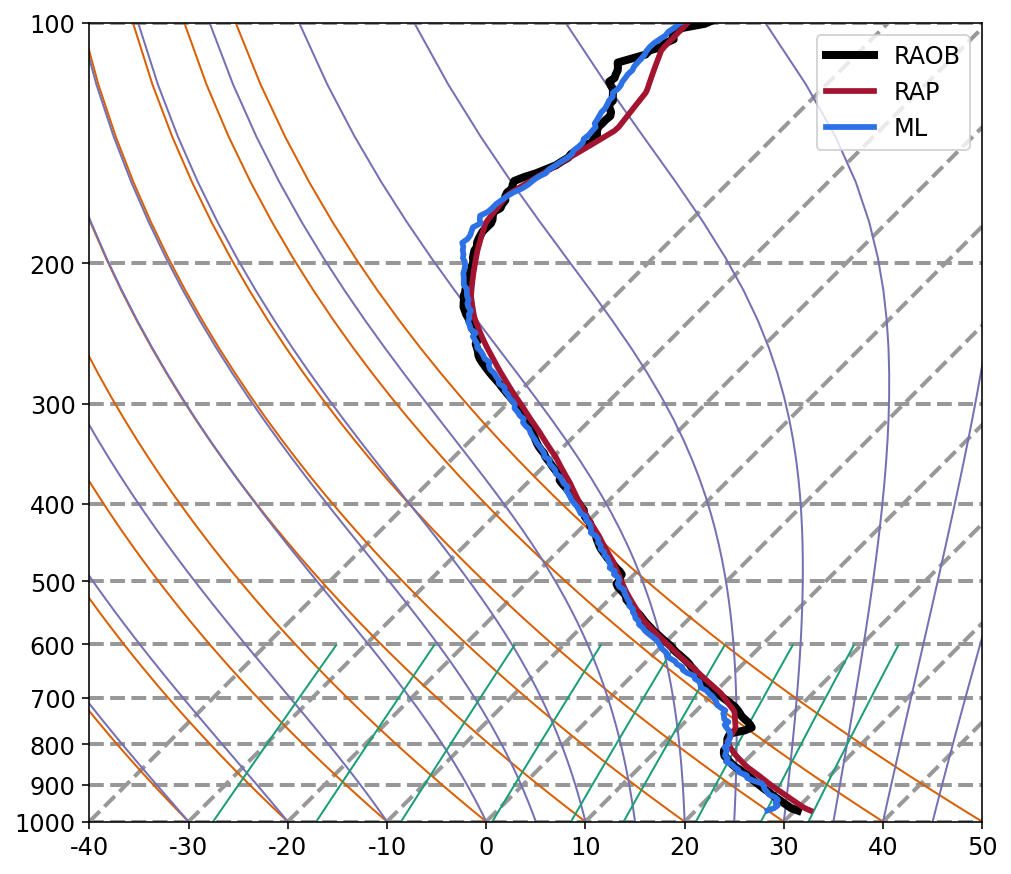

In [94]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [40]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [8]}


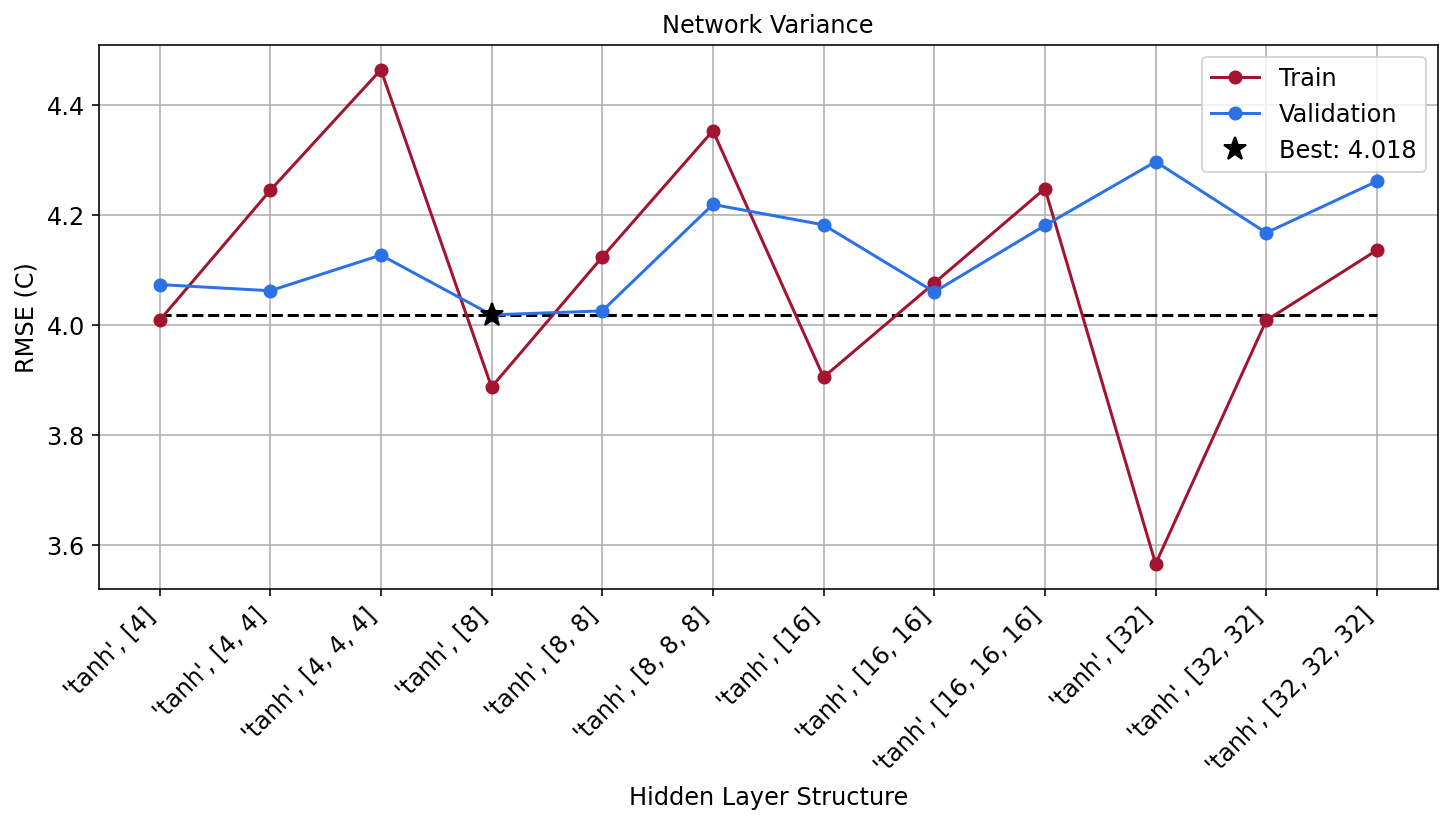

In [53]:
activations = ['tanh']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

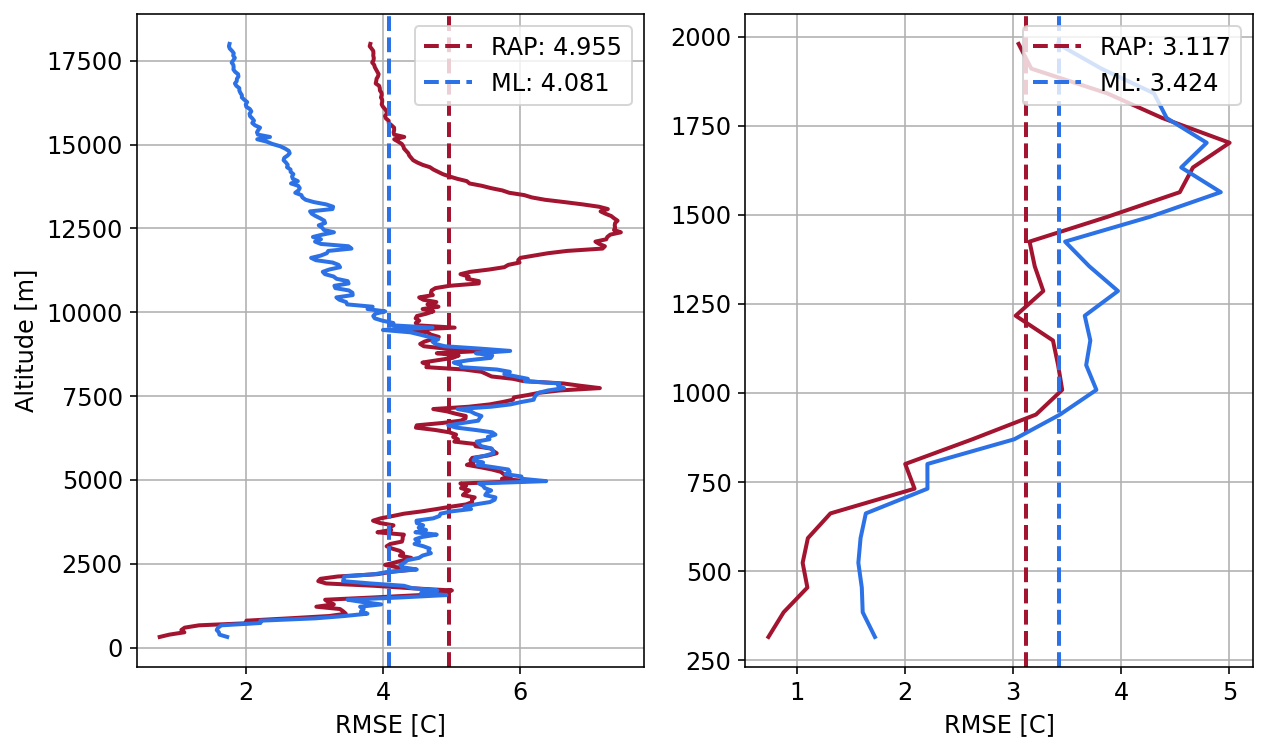

In [54]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

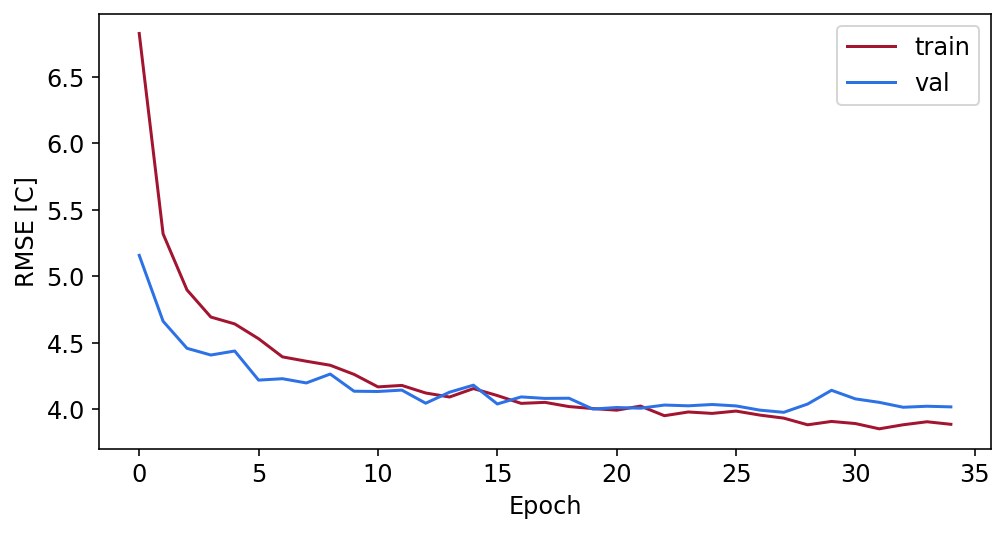

In [55]:
plot_loss(nnet)

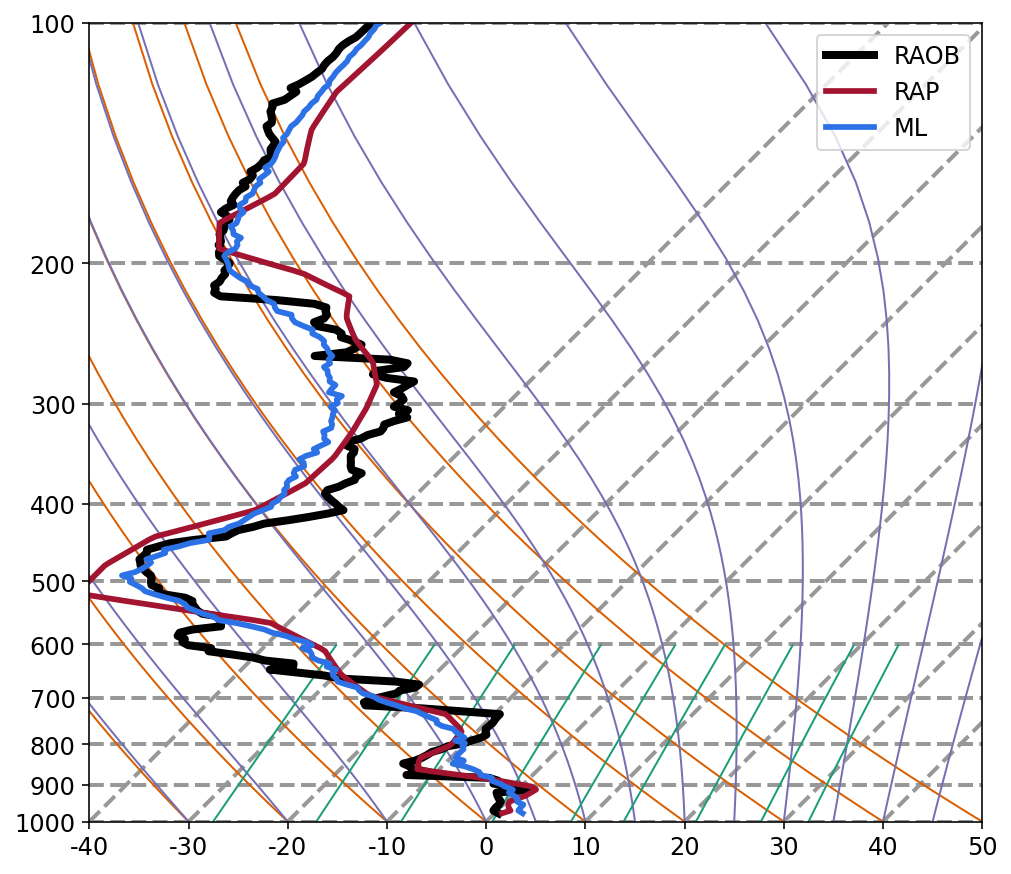

In [56]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## UNet Model

### Temperature

In [95]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

In [146]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
           learning_rate=0.001, validation=[Xtest, Ttest])

SkipNeuralNetwork((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.05363 in 6.8629 seconds.

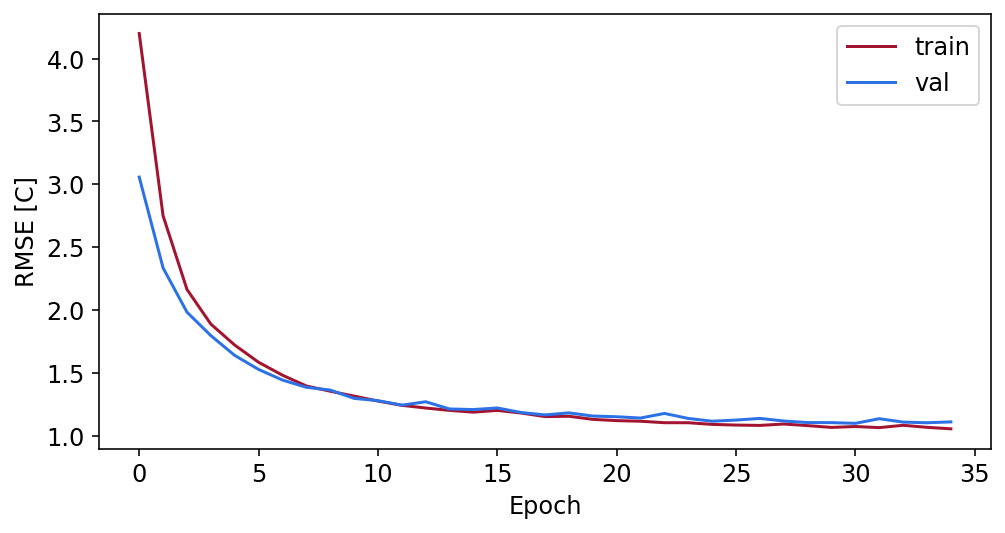

In [147]:
plot_loss(nnet)

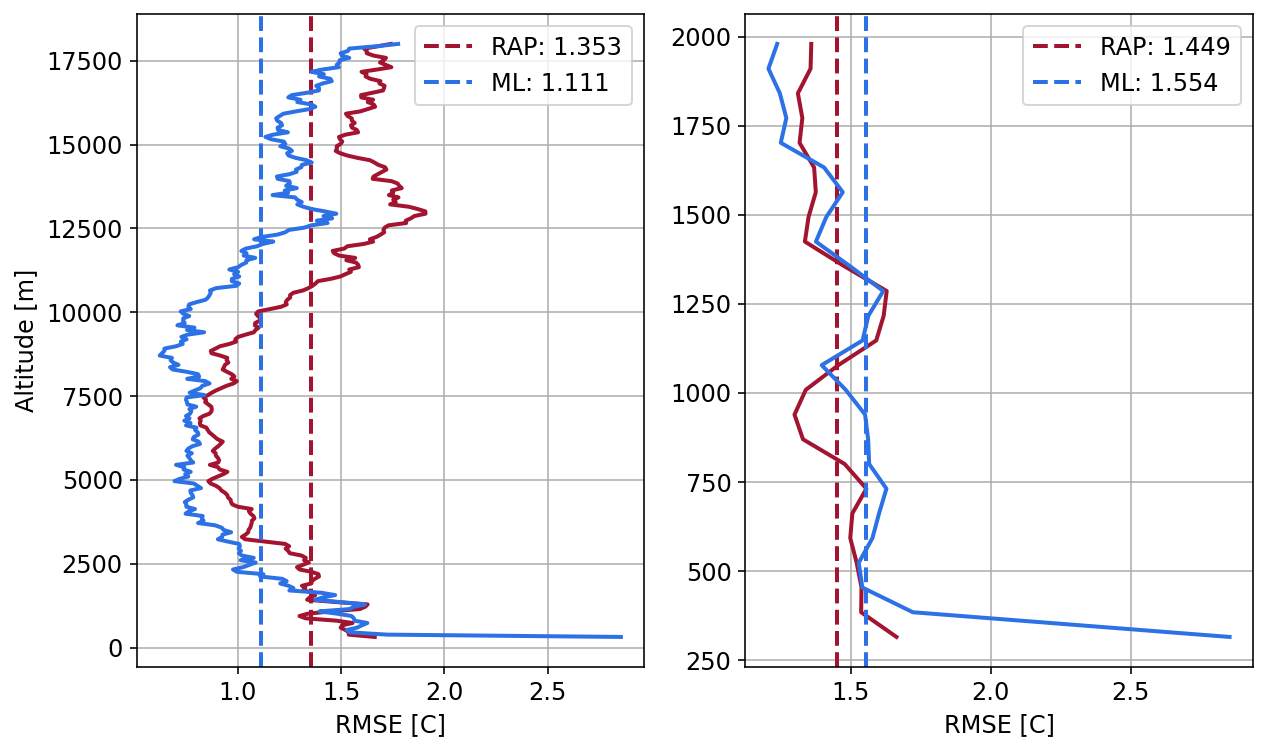

In [148]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

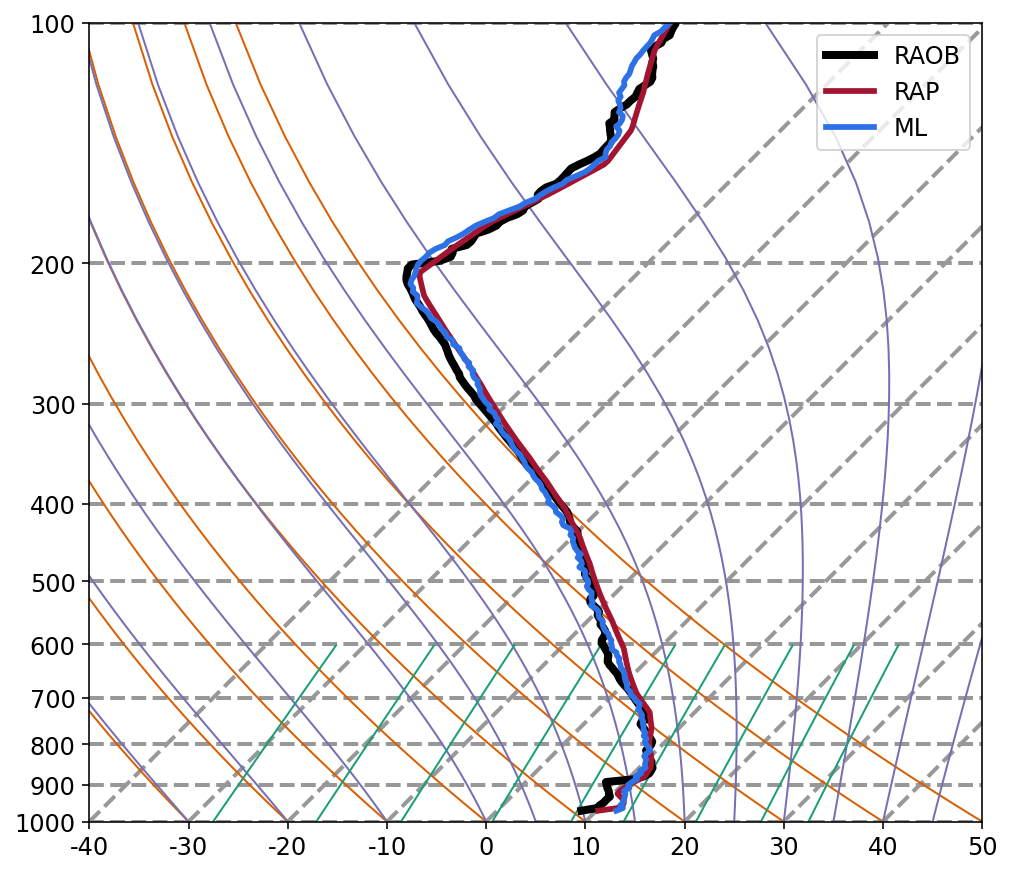

In [132]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

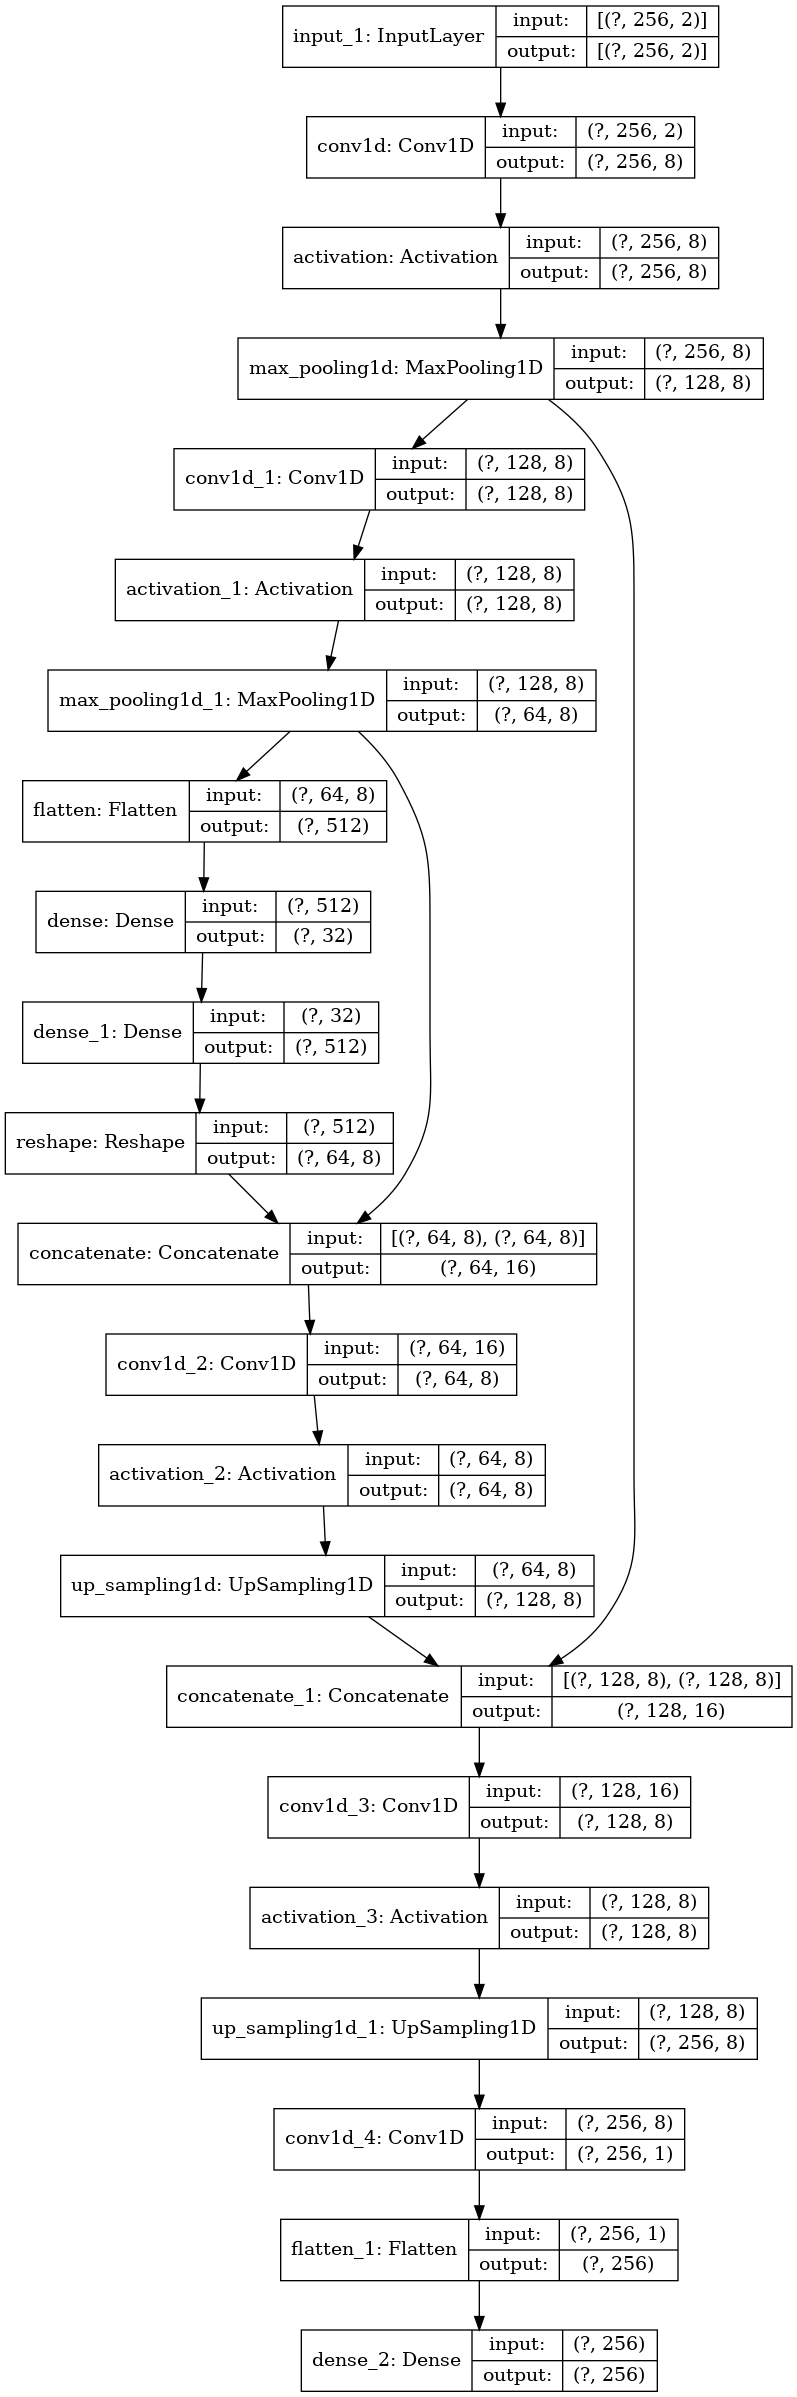

In [149]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/unet.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [57]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

In [58]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
           learning_rate=0.001, validation=[Xtest, Ttest])

SkipNeuralNetwork((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.19975 in 15.5353 seconds.

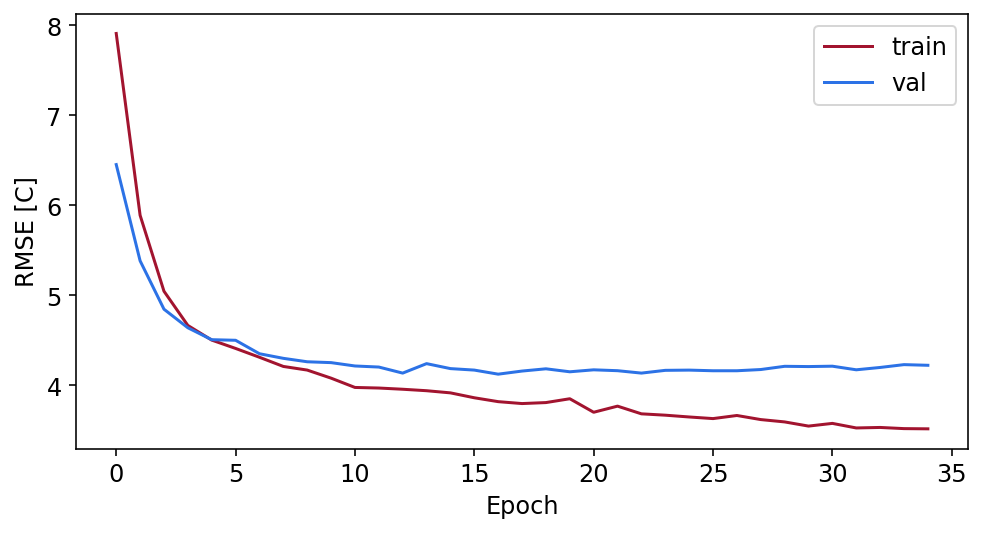

In [59]:
plot_loss(nnet)

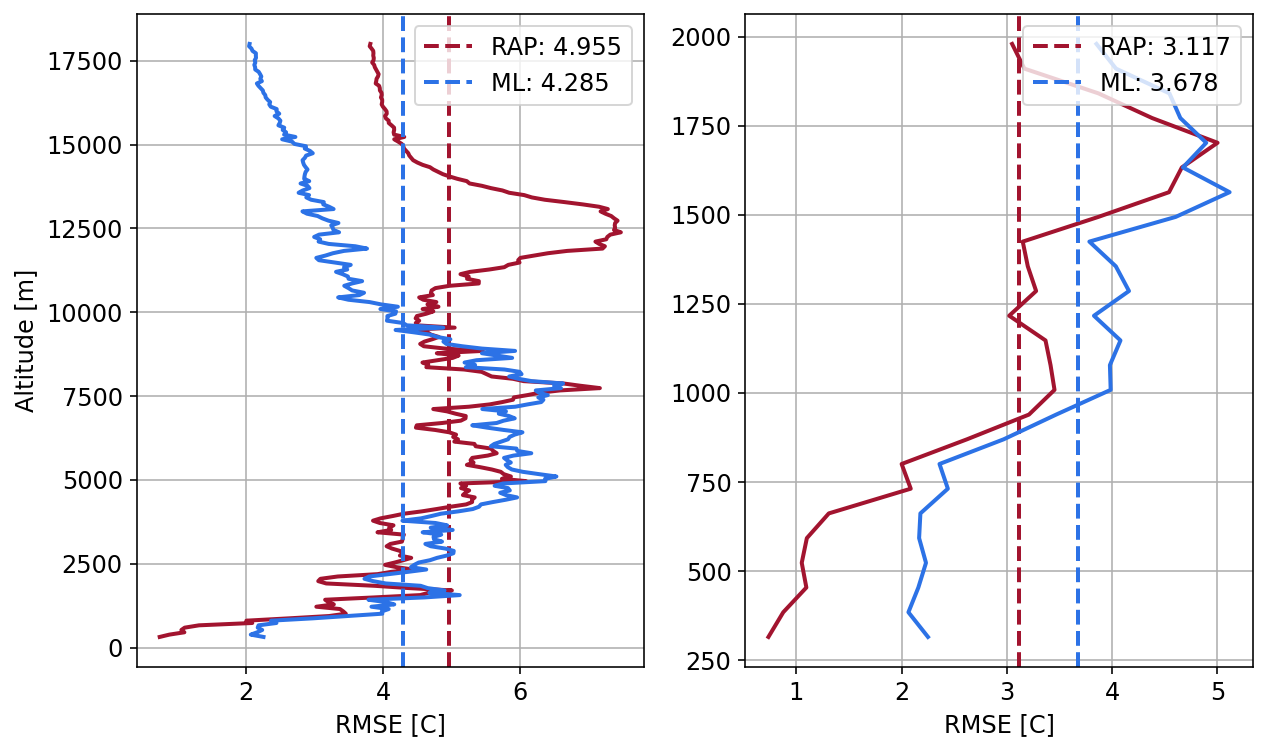

In [60]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

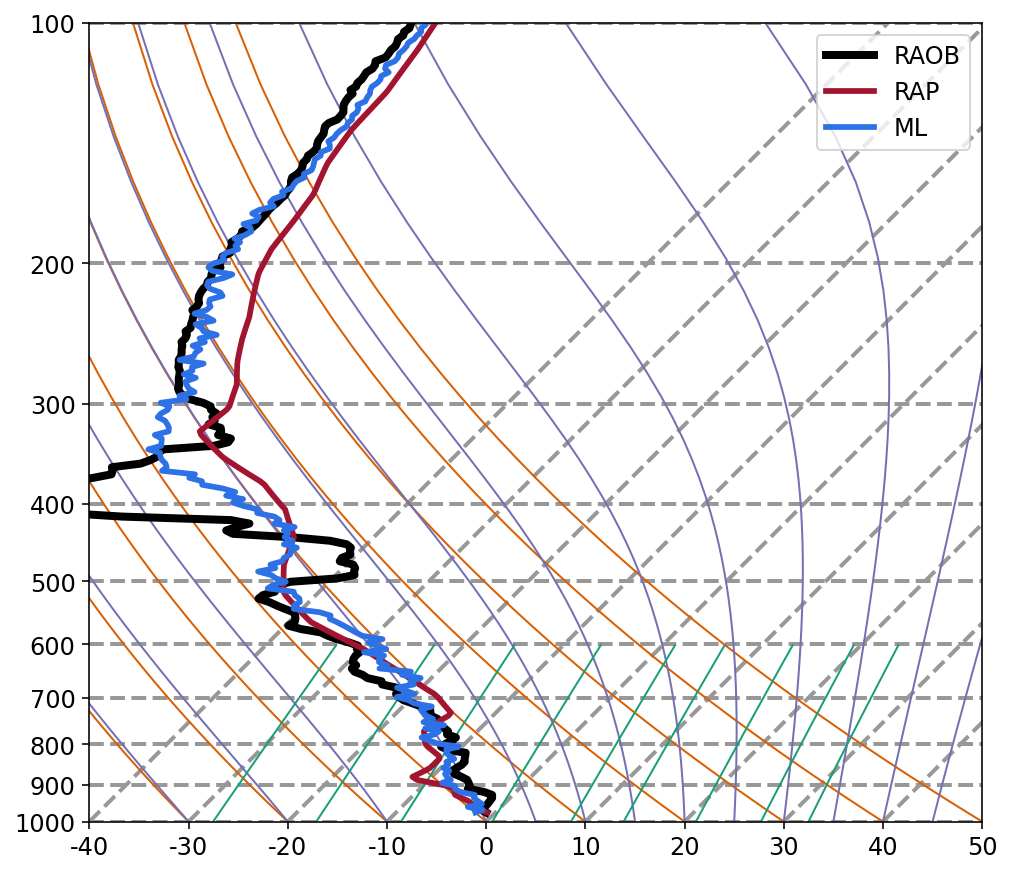

In [61]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Transfer Learning RAOB

Best performance is noticed when retraining over the entire model, or freezing the weights before the latent vector.

In [9]:
def insert_intermediate_layer(model, layer_regex, layer_factory):
    x = model.layers[0].output
    for layer in model.layers[1:]:
        x = layer(x)
        if re.match(layer_regex, layer.name):
            new_layer = layer_factory()
            new_layer._name = f'{layer.name}_{new_layer.name}'
            x = new_layer(x)
            print(f'Added {new_layer.name} after {layer.name}')
    return tf.keras.Model(model.layers[0].input, x)

In [12]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [PRESSURE, DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((588, 256, 2), (588, 256), (147, 256, 2), (147, 256))

In [34]:
## 0.970 with raob_cae freeze before `dense` with 20, 32, 0.0001 'adam'

# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_cae')
nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_moisture_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_temperature_cnn')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_temperature_cae')

def dropout_layer_factory():
    return tf.keras.layers.Dropout(rate=0.2, name='dropout')
def batchnorm_layer_factory():
    return tf.keras.layers.BatchNormalization(name='batch_norm')

# (?<![\w\d])dense(?![\w\d])
# nnet.model = insert_intermediate_layer(nnet.model, '(?<![\w\d])conv1d(?![\w\d])', batchnorm_layer_factory)
# nnet.model = insert_intermediate_layer(nnet.model, 'max_pool', dropout_layer_factory)

for layer in nnet.model.layers[:-2]:
    if layer == nnet.model.get_layer('dense'):
        break
    layer.trainable = False
    
# Remove last Dense layer and add new one.
# x = nnet.model.layers[-2].output
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(256)(x)
# nnet.model = tf.keras.Model(nnet.model.layers[0].input, x)
    
nnet.train(Xtrain, Ttrain, 10, 32, validation=[Xtest, Ttest], method='adam',
                 learning_rate=0.001, verbose=True)

epoch: 0, rmse 4.30862, val_rmse 4.06458
epoch: 5, rmse 3.75719, val_rmse 3.93934
epoch: 9, rmse 3.63248, val_rmse 3.95662
finished!


ConvolutionalAutoEncoder((256, 2), [4, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.20963 in 2.9439 seconds.

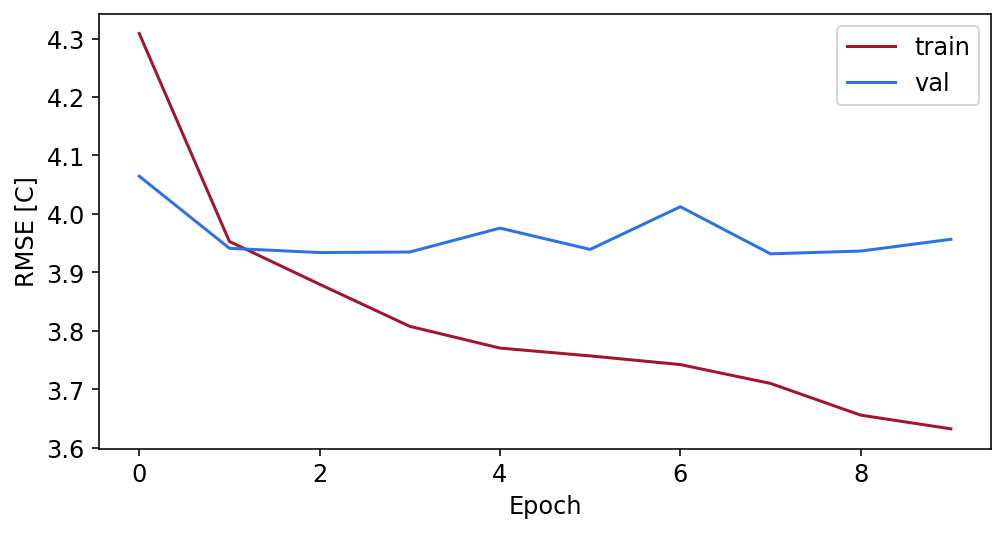

In [35]:
plot_loss(nnet)

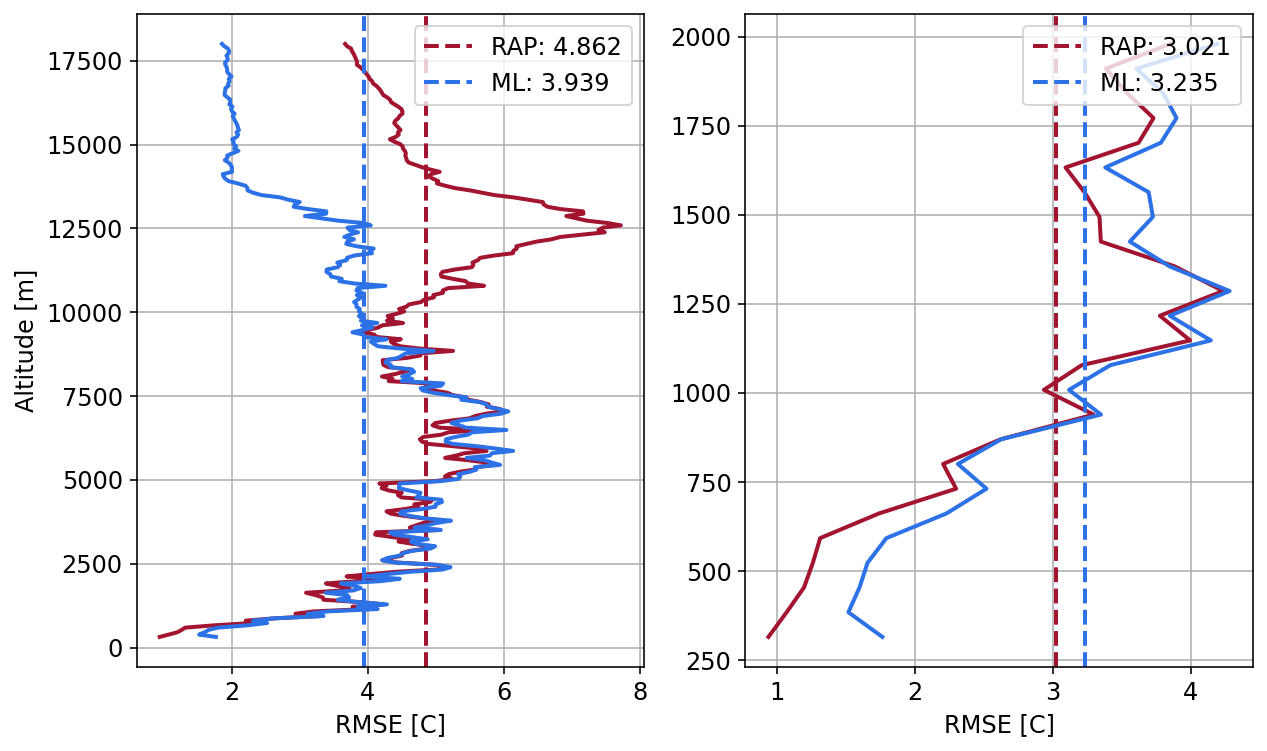

In [36]:
plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                            # file_name=f"/home/stock/research/media/transferlearning-temp-profile.png")

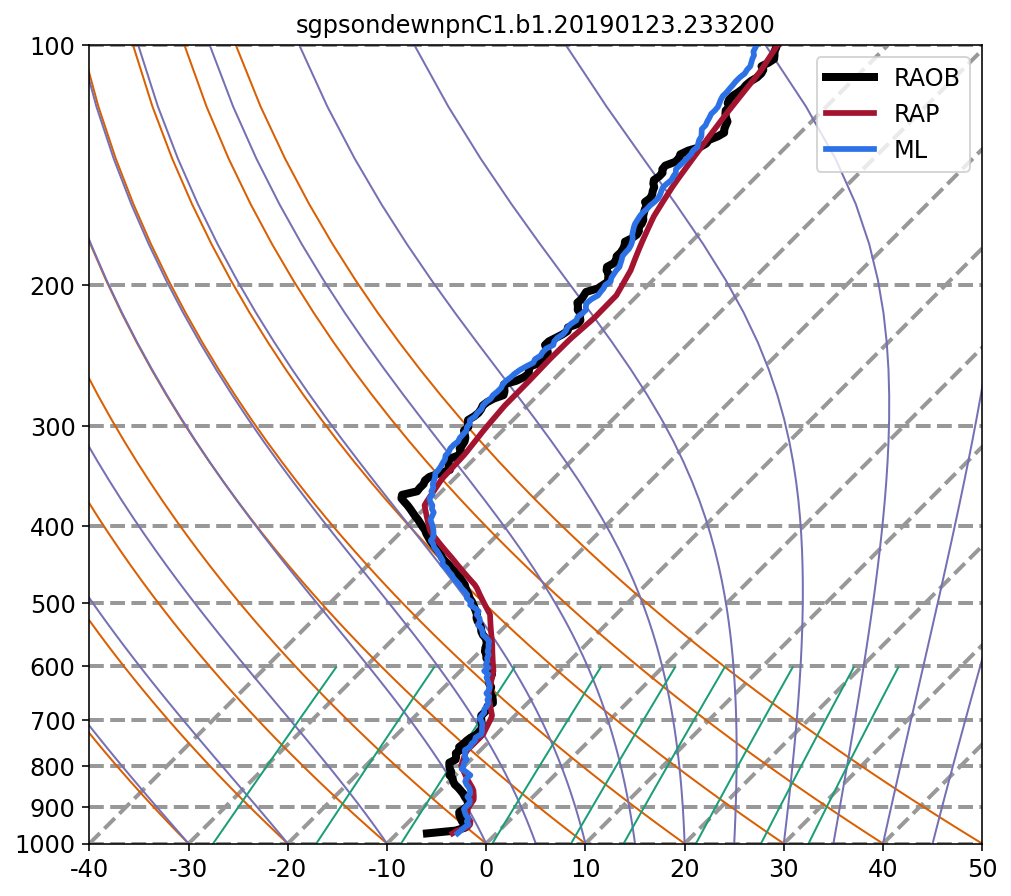

In [50]:
i = 69 # 69
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1])[0]

# sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = Ttest[i,:,1]
# sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = Xtest[i,:,DEWPOINT]
# sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = moist_nnet.use(Xtest[i:i+1,:,[PRESSURE,DEWPOINT]])[0]

title = sonde_files[i].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");